# Analysis of eating patterns in CALERIE participants

The data analyzed in this notebook comes from Phase II of the [CALERIE study](https://calerie.duke.edu) which examined the effects of caloric restriction on many different health outcomes and biomarkers over two years. In this notebook we examine the relationships between the timing of food consumption on weight loss and caloric restriction among the study participants.

It is well established that the quantity and quality of the food we consume can affect our health. Now it is becoming clear that when we eat also plays a key role in health and disease \[[Manoogian et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7213043/)\], which is the reason for this analysis.

If you wish to replicate these analyses yourself, you will need to obtain both the complete Public Use Database and the file foodtime.CSV from the [administrators of the CALERIE study](https://calerie.duke.edu/samples-data-access-and-analysis).  The file foodtime.CSV is not part of the normal Public Use Database distribution, so you will need to request it specifically. It contains the timing of individual meals in the participant's food logs.

# Load data
From a combination of ascii flat files 

In [1]:
import pandas as pd
import seaborn as sns
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.display import display

from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.anova import anova_lm

from pathlib import Path

%matplotlib inline

sns.set(font_scale = 1.12)
sns.set_style('white')

! pip list


Package                            Version            
---------------------------------- -------------------
alabaster                          0.7.12             
anaconda-client                    1.7.2              
anaconda-navigator                 1.9.12             
anaconda-project                   0.8.3              
applaunchservices                  0.2.1              
appnope                            0.1.0              
appscript                          1.0.1              
argh                               0.26.2             
asn1crypto                         1.3.0              
astroid                            2.3.3              
astropy                            4.0                
atomicwrites                       1.3.0              
attrs                              19.3.0             
autopep8                           1.4.4              
Babel                              2.8.0              
backcall                           0.1.0              
backports.

In [2]:
! python --version

Python 3.7.6


In [3]:
path = './analysis_ascii_data/'
files = glob.glob(path+'*.CSV')
dtables = {}
for afile in files:
    fname = afile.split('/')[-1].split('.')[0]
    print(fname)  
    df = pd.read_csv(afile)
    dtables[fname] = df


POMSA
CLWTLONG
SUBJECT1
IVRSRAND
BSQA
HOMEWT
SFLABLNG
TEERESID
FORMATS
SFLABFLT
FCI
TEERQ
CANTABA
WELQA
HEMATOL
PCTCRVIS
PARVISIT
FCQTRTA
PAL
DXAA
DLWLONG
BDI
VO2MAX
CLWTVIS
FCQSTATA
BONELAB
PCTCRST
PSSA
PSQI
PCTCR
CORETMPA
RMRRESID
OCLABFLT
ECGA
FOODWEEK
COGBIAS
DEROGATI
OCLABLNG
RXCAL
BIOPSYA
ISOMETRA
RANDSF36
AE
HANDGRPA
TFEQ
SAE
AREERESD
DTH
RMRA
VISITS
VITALSA
MAEDSA


In [4]:
# these are the people who actually completed the study!!
participants = dtables['SUBJECT1'].query('txcomp=="Completed Intervention"')[['deidnum']].set_index('deidnum').join(dtables['IVRSRAND'].set_index('deidnum'))['tx'].to_frame()
participants.reset_index().groupby('tx').count()

,deidnum
tx,
Caloric Restriction,117
Control,71


In [5]:
foodwk = dtables['FOODWEEK']['kcal'].apply(lambda x: np.NaN if x==' ' else float(x)).to_frame().join( dtables['FOODWEEK'][['deidnum','visit']] ).set_index('deidnum')
foodwk['period']= foodwk.visit.apply(lambda x: 'Baseline' if x[0]=='B' else 'Intervention')
foodwk['year'] = foodwk.visit.apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if int(x[-2:]) <= 12 else 'Year 2')
foodwk = foodwk.join(participants,how='inner')
kcals_period = foodwk.groupby(['deidnum','period'])['kcal'].mean().unstack()
kcals_visit = foodwk.groupby(['deidnum','visit'])['kcal'].mean().unstack()
kcals_year = foodwk.groupby(['deidnum','year'])['kcal'].mean().unstack()

In [6]:
dtables['FOODWEEK'].query('visit == "Baseline"').join(dtables["SUBJECT1"],on='deidnum',rsuffix='subj1')

,deidnum,pagenum,visit,subvisit,fooddt1,foodcrf,foodnds,fdndrsn,nndsdays,tgrams,...,sdrpproc,sdrprsch,sdrprand,sdrptran,sdrpchld,sdrprefx,sdrpcont,sdrpothr,bdrpcnst,bdrpaevt
0,903,,Baseline,,163,1,1,,6,3552.8851667,...,,,,,,,,,,1
2,1057,,Baseline,,-50,1,1,,12,1328.9823333,...,,,,,,,,,,
9,1948,,Baseline,,-9,1,1,,12,2561.6226667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,2081,,Baseline,,-87,1,1,,12,2230.5380833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,2230,,Baseline,,-45,1,1,,12,1468.17175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,98688,,Baseline,,-55,1,1,,12,2061.9970833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,99093,,Baseline,,-60,1,1,,12,2370.1475833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1338,99325,,Baseline,,-29,1,1,,12,1870.4975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1343,99413,,Baseline,,-49,1,1,,12,1192.6579167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
food = pd.read_csv('satchins_data/foodtime.CSV').set_index('deidnum').join(participants,how='inner').reset_index()
dtables['FOOD']=food
ampm = food.mealtime.apply(lambda x: x[-2])

pmoffset = food.mealtime.apply(lambda x: 0 if x[-2]=='A' else 12 if x[-2]=='P' else None )

hrs = food.mealtime.apply(lambda x: int(x[:-3].split(':')[0]))

pmoffset = pmoffset - 12*(  (hrs==12) ) #take care of the 12AM and 12PM garbage

mins = food.mealtime.apply(lambda x: int(x[:-3].split(':')[1] if ':' in x else 0))

ltime = hrs+pmoffset + mins/60.
ltime = ltime.rename('Hour of day')

ltime = ltime + 24 * (ltime<4.0)

meals = ltime.to_frame().join( food.mealtime ).join( food[[ 'intakedt', 'deidnum', 'mealname', 'mealloc', 'KCAL', 'tx', 'visname' ]] )#.join( dtables['IVRSRAND'].set_index('deidnum').tx, on='deidnum')

# these divisions based on where it looks like the breakpoints are in 
# meals.intakedt.hist(bins=np.arange(-200,900,40))
# np.sort( meals.intakedt.unique() )
# but it turns out this isn't accurate for a few dozen entries
# meals['year'] = meals.intakedt.apply( lambda x: 'Baseline' if x<12 else 'Year 1' if x<450 else 'Year 2')
# meals['condition'] = meals.intakedt.apply( lambda x: 'Baseline' if x<12 else 'Intervention' )
# below is better since it's the actually recorded visit name
meals['year'] = meals.visname.apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if (x in ['M6','M12']) else 'Year 2')
meals['condition'] = meals.visname.apply( lambda x: 'Baseline' if x[0]=='B' else 'Intervention')

# some elements seem to get read in as str instead of float, because there is one line with " "
vals = []
labels = []
for k,el in meals.KCAL.iteritems(): 
    if el==' ':
        vals.append( np.nan )
    else:
        vals.append(float(el))
    labels.append(k)
meals.loc[:,'KCAL'] = pd.Series(data=vals,index=labels)
        
dtables['MEALS']=meals



/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,114,115,117,118,119,120,121,122,123,124,125,126,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Define functions 
Things that we will be using in various analyses. This really needs some commenting and cleanup.

In [8]:
def get_measure_variables(mtab, mvar, mtvar, gtab, gvar, gtvar):

    group_on = dtables[gtab].set_index(['deidnum',gtvar])[gvar].unstack(gtvar).apply( lambda y: y.apply(lambda x: np.NaN if x==' ' else float(x)))#.join(participants,how='inner')
    group_on.columns = group_on.columns.to_series().apply(lambda x: gvar+x.replace(' ',''))

    measure_on = dtables[mtab].set_index(['deidnum',mtvar])[mvar].unstack(mtvar).apply( lambda y: y.apply(lambda x: np.NaN if x==' ' else float(x)))#.join(participants,how='inner')
    measure_on.columns = measure_on.columns.to_series().apply(lambda x: mvar+x.replace(' ',''))
    measure_on = measure_on.join(group_on).join( participants, how='inner')
    
    return measure_on






In [9]:
def add_grouping(data, gvar, cut1=0.25, cut2=0.75, labels=['low','mid','high'], subvar=None, subval=None):
    with pd.option_context('mode.chained_assignment',None):
        dd = data.copy().reset_index()

        if subvar:
            dd=dd.loc[ (dd[subvar] == subval) ]

        c1 = dd[gvar].quantile(cut1)
        c2 = dd[gvar].quantile(cut2)

        lows = data.loc[ (data[gvar] <= c1) ].index.get_level_values('deidnum').unique()
        lows = data.query('deidnum in @lows').index

        highs = data.loc[ (data[gvar] > c2) ].index.get_level_values('deidnum').unique()
        highs = data.query('deidnum in @highs').index

        data[gvar+' grouping'] = labels[1]
        data.loc[lows,gvar+' grouping'] = labels[0]
        data.loc[highs,gvar+' grouping'] = labels[2]
    
    return data

def add_grouping_by_condition(data, gvar, **kwargs):
    ctrlmeas = add_grouping(data.query('tx == "Control"'), gvar, **kwargs)
    cresmeas = add_grouping(data.query('tx == "Caloric Restriction"'), gvar, **kwargs)
    return pd.concat([ctrlmeas, cresmeas])
 

In [10]:
   
def add_grouping_ignore_visit(data, gvar, cut1=0.33, cut2=0.66, labels=['low','mid','high'], subvar=None, subval=None):
    dd = data.copy().reset_index()

    if subvar:
        dd=dd.loc[ (dd[subvar] == subval) ]
        
    c1 = dd[gvar].quantile(cut1)
    c2 = dd[gvar].quantile(cut2)
    
    #wrong! when index contains multiple visits for same deidnum with differnt terciles
    # lows = data.loc[ (data[gvar] <= c1) ].index.get_level_values('deidnum').unique()
    # lows = data.query('deidnum in @lows').index
    lows = data.loc[ (data[gvar] <= c1) ].index
    
    #highs = data.loc[ (data[gvar] > c2) ].index.get_level_values('deidnum').unique()
    #highs = data.query('deidnum in @highs').index
    highs = data.loc[ (data[gvar] > c2) ].index

    data[gvar+' grouping'] = labels[1]
    data.loc[lows,gvar+' grouping'] = labels[0]
    data.loc[highs,gvar+' grouping'] = labels[2]
    
    return data


def add_quartile_ignore_visit(data, gvar, labels=['1st quartile','2nd quartile','3rd quartile','4th quartile'], subvar=None, subval=None):
    dd = data.copy().reset_index()

    if subvar:
        dd=dd.loc[ (dd[subvar] == subval) ]
        
    c1 = dd[gvar].quantile(0.25)
    c2 = dd[gvar].quantile(0.5)
    c3 = dd[gvar].quantile(0.75)
    

    lows = data.loc[ (data[gvar] <= c1) ].index
    mid1 = data.loc[ (data[gvar] > c1) & (data[gvar] <= c2)].index
    mid2 = data.loc[ (data[gvar] > c2) & (data[gvar] <= c3)].index
    highs = data.loc[ (data[gvar] > c3) ].index

    data.loc[lows,gvar+' grouping'] = labels[0]
    data.loc[mid1,gvar+' grouping'] = labels[1]
    data.loc[mid2,gvar+' grouping'] = labels[2]
    data.loc[highs,gvar+' grouping'] = labels[3]
    
    return data

In [11]:
def shift_row_to_bottom(df, index_to_shift):
 
  idx = df.index.tolist()
  idv = idx.pop(index_to_shift)
  df = df.reindex(idx + [idv])
  
  return df


In [12]:
def linear_models(ddat, v, robust=False):
    ''' creates models M1,2,3 (see desc in Linear Models sec below)
    v: variable of interest (indep)
    robust: set True if you want to drop extremes of v
    '''

    
    # check robustness by getting rid of people who are >97.5%ile or <2.5%ile
    if (robust):
        dc = ddat[v].quantile(0.025)
        todrop1 = ddat.index[ ddat[v]<dc ].to_series()
        dc = ddat[v].quantile(0.975)
        todrop2 = ddat.index[ ddat[v]>dc ].to_series()
        todrop = pd.concat([todrop1, todrop2])
    else:
        # or don't if this is uncommented below (eliminates todrop)
        todrop=[]

    print('Out of {} datapoints, dropping {}'.format( len(ddat), len(todrop)) )
    ll = ddat.drop(todrop).reset_index()

    o='weight change %' # this is for Models M1 and M2
    # get rid of string problems in the data and missing data that occur sometimes
    with pd.option_context('mode.chained_assignment',None):
        ddat[o] = ddat[o].apply( lambda x: np.NaN if ( (type(x)==str) and x.isspace()) else float(x) )
    ddat = ddat.dropna(subset=[v,o])
           
    # remove problem characters from variable names to make LMER style formulas work
    ny = o.replace(' ','_').replace('%','pct')
    nx = v.replace(' ','_').replace('%','pct')
    ndat = ll.rename({o:ny, v:nx, 'caloric restriction %':'caloric_restriction_pct'},axis=1)
    
    
    # Model M1
    formula = '{} ~ {}  * caloric_restriction_pct'.format(ny,nx)
    print(formula)
    model = ols(formula,ndat).fit()

    h = sns.lmplot(data=ll, x=v, y=o, hue='CR% quartiles',
                  hue_order=['1st quartile','2nd quartile','3rd quartile','4th quartile'])
    
    sns.despine()
    plt.savefig(outdir+nx+'_pctcr_quartile_'+ny+'.png',dpi=300)

    with open(outdir+'tab1_'+nx+'_pctcr_quartile_'+ny+'.csv','w') as csvf:
        csvf.write(model.summary().as_csv())
        csvf.close()

    res = anova_lm(model)
    var_explained = (res['sum_sq']/res['sum_sq'].sum()).rename('Var explained')
    results_summary = model.summary()
    results_as_html = results_summary.tables[1].as_html()
    outputm1 = pd.read_html(results_as_html, header=0, index_col=0)[0].join(var_explained, how='outer')
    outputm1 = shift_row_to_bottom(outputm1,1)


    display(model.summary())
    display(outputm1)
    
    
    # Model M2
    formula = '{} ~ {} '.format(ny,nx)
    print(formula)
    model = ols(formula,ndat).fit()

    h = sns.lmplot(data=ll, x=v, y=o)

    sns.despine()
    plt.savefig(outdir+nx+'_'+ny+'.png',dpi=300)

    with open(outdir+'tab1_'+nx+'_'+ny+'.csv','w') as csvf:
        csvf.write(model.summary().as_csv())
        csvf.close()

    res = anova_lm(model)
    var_explained = (res['sum_sq']/res['sum_sq'].sum()).rename('Var explained')
    results_summary = model.summary()
    results_as_html = results_summary.tables[1].as_html()
    outputm2 = pd.read_html(results_as_html, header=0, index_col=0)[0].join(var_explained, how='outer')
    outputm2 = shift_row_to_bottom(outputm2,1)


    display(model.summary())
    display(outputm2)
    
    # Model M3
    o='caloric restriction %' 
    # remove problem characters from variable names to make LMER style formulas work
    # get rid of string problems in the data and missing data that occur sometimes
    with pd.option_context('mode.chained_assignment',None):
        ddat[o] = ddat[o].apply( lambda x: np.NaN if ( (type(x)==str) and x.isspace()) else float(x) )
    ddat = ddat.dropna(subset=[v,o])
    
    ny = o.replace(' ','_').replace('%','pct')
    ndat = ndat.rename({o:ny},axis=1)
    formula = '{} ~ {} '.format(ny,nx)
    print(formula)

    model = ols(formula,ndat).fit()

    h = sns.lmplot(data=ll, x=v, y=o)


    plt.savefig(outdir+nx+'_'+ny+'.png',dpi=300)

    with open(outdir+'tab1_'+nx+'_'+ny+'.csv','w') as csvf:
        csvf.write(model.summary().as_csv())
        csvf.close()

    res = anova_lm(model)
    var_explained = (res['sum_sq']/res['sum_sq'].sum()).rename('Var explained')
    results_summary = model.summary()
    results_as_html = results_summary.tables[1].as_html()
    outputm3 = pd.read_html(results_as_html, header=0, index_col=0)[0].join(var_explained, how='outer')
    outputm3 = shift_row_to_bottom(outputm3,1)
 
    display(model.summary())
    display(outputm3)
    
    with open(outdir+'model_summary_'+nx+'.csv','w') as csvf:
        csvf.write('M1  dep var: weight_change_pct,,,,,,\n')
        outputm1.to_csv(csvf)
        csvf.write(',,,,,,\nM2  dep var: weight_change_pct,,,,,,\n')
        outputm2.to_csv(csvf,header=False)
        csvf.write(',,,,,,\nM3  dep var: caloric_restriction_pct,,,,,,\n')
        outputm3.to_csv(csvf,header=False)
        csvf.close()

# Creating some tables that will be reused in many analyses
- The percentiles of eating duration
- the time of 50% calorie intake
- the time of 95% eating interval
- a wide table called `newmeas` that combines lots of variables in teh SQL tables plus the eating timing variables above

In [13]:
meals['visit'] = meals.visname.apply( lambda x: 'BL' if x[0]== 'B' else 'M06' if x=='M6' else x) # convert subvisits to single baseline
ptile_visit = meals.groupby(['deidnum','tx','visit'])['Hour of day'].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])#.unstack() -- seems there are some version differences
ll = ['2.5%','5%','10%','12.5%','25%']
ul = ['97.5%','95%', '90%','87.5%', '75%']
mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
for low, upp, midp in zip(ll,ul,mp):
    ptile_visit[midp] = ptile_visit[upp] - ptile_visit[low]
    
ptile_visit[mp]

duration mid 95%  duration mid 90%  \
deidnum tx                  visit                                       
1057    Caloric Restriction BL            16.525000           14.2000   
                            M06           13.408333           13.1250   
                            M12           14.625000           13.0000   
                            M18           12.750000           12.5000   
                            M24           14.200000           14.0000   
...                                             ...               ...   
99413   Caloric Restriction M18           14.000000           13.3000   
                            M24           13.375000           12.9375   
99866   Control             BL            13.000000           13.0000   
                            M12           12.525000           12.0500   
                            M24           12.883333           12.6000   

                                   duration mid 80%  duration mid 75%  \
deidnum tx                  visit                                       
1057    Caloric Restriction BL            11.866667         10.916667   
                            M06           11.100000         10.687500   
                            M12           11.500000         11.250000   
                            M18           11.500000         11.250000   
                            M24           13.400000         12.500000   
...                                             ...               ...   
99413   Caloric Restriction M18           11.650000         10.937500   
                            M24           11.916667         11.656250   
99866   Control             BL            12.700000         12.083333   
                            M12           11.100000         10.812500   
                            M24           11.800000         11.437500   

                                   duration mid 50%  
deidnum tx                  visit                    
1057    Caloric Restriction BL             9.000000  
                            M06            9.125000  
                            M12            9.000000  
                            M18            9.500000  
                            M24            8.500000  
...                                             ...  
99413   Caloric Restriction M18            7.500000  
                            M24            8.291667  
99866   Control             BL             9.250000  
                            M12            7.500000  
                            M24            9.125000  

[786 rows x 5 columns]

In [14]:
ptile_year = meals.groupby(['deidnum','tx','year'])['Hour of day'].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])#.unstack() -- seems there are some version differences
ll = ['2.5%','5%','10%','12.5%','25%']
ul = ['97.5%','95%', '90%','87.5%', '75%']
mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
for low, upp, midp in zip(ll,ul,mp):
    ptile_year[midp] = ptile_year[upp] - ptile_year[low]
    
ptile_year[mp]

duration mid 95%  duration mid 90%  \
deidnum tx                  year                                           
1057    Caloric Restriction Baseline         16.525000         14.200000   
                            Year 1           13.327083         13.212500   
                            Year 2           14.000000         13.875000   
1948    Control             Baseline         16.000000         15.000000   
                            Year 1           14.000000         14.000000   
...                                                ...               ...   
99413   Caloric Restriction Year 1           13.737500         12.325000   
                            Year 2           13.945833         13.454167   
99866   Control             Baseline         13.000000         13.000000   
                            Year 1           12.525000         12.050000   
                            Year 2           12.883333         12.600000   

                                      duration mid 80%  duration mid 75%  \
deidnum tx                  year                                           
1057    Caloric Restriction Baseline         11.866667         10.916667   
                            Year 1           12.500000         11.875000   
                            Year 2           12.500000         12.000000   
1948    Control             Baseline         12.600000         12.000000   
                            Year 1           12.500000         10.875000   
...                                                ...               ...   
99413   Caloric Restriction Year 1           11.500000         11.500000   
                            Year 2           11.808333         11.593750   
99866   Control             Baseline         12.700000         12.083333   
                            Year 1           11.100000         10.812500   
                            Year 2           11.800000         11.437500   

                                      duration mid 50%  
deidnum tx                  year                        
1057    Caloric Restriction Baseline            9.0000  
                            Year 1              9.1250  
                            Year 2              9.1250  
1948    Control             Baseline            8.0000  
                            Year 1              7.3125  
...                                                ...  
99413   Caloric Restriction Year 1              8.0000  
                            Year 2              8.2500  
99866   Control             Baseline            9.2500  
                            Year 1              7.5000  
                            Year 2              9.1250  

[556 rows x 5 columns]

In [15]:
# A rolling mean version of the interval metric
with pd.option_context('mode.chained_assignment',None):
    ptilevis = []
    for name, group in ptile_visit.groupby('deidnum'):
        group['duration mid 95% rolling'] = group['duration mid 95%'].rolling(5, min_periods=1).mean()
        ptilevis.append( group )
    ptilevis = pd.concat(ptilevis)
    
ptilevis

count       mean       std       min  \
deidnum tx                  visit                                         
1057    Caloric Restriction BL      53.0  14.933962  4.865646  7.250000   
                            M06     23.0  14.847826  4.765436  7.500000   
                            M12     21.0  13.964286  4.958758  7.750000   
                            M18     21.0  13.785714  4.752819  7.000000   
                            M24     25.0  14.940000  5.186260  7.000000   
...                                  ...        ...       ...       ...   
99413   Caloric Restriction M18     28.0  13.714286  4.441864  7.000000   
                            M24     26.0  14.096154  4.547447  7.250000   
99866   Control             BL      40.0  13.279167  4.665963  7.000000   
                            M12     20.0  14.350000  4.383282  8.000000   
                            M24     18.0  13.712963  4.821590  7.333333   

                                       2.5%      5%       10%     12.5%  \
deidnum tx                  visit                                         
1057    Caloric Restriction BL     7.475000  8.3000  9.033333  9.333333   
                            M06    7.591667  7.8250  9.400000  9.812500   
                            M12    7.875000  8.0000  8.000000  8.000000   
                            M18    7.250000  7.5000  8.000000  8.000000   
                            M24    7.000000  7.0000  7.400000  8.000000   
...                                     ...     ...       ...       ...   
99413   Caloric Restriction M18    7.000000  7.0000  7.350000  7.875000   
                            M24    7.250000  7.3125  7.500000  7.666667   
99866   Control             BL     7.000000  7.0000  7.000000  7.000000   
                            M12    8.000000  8.0000  8.900000  9.187500   
                            M24    7.404167  7.4750  7.500000  7.562500   

                                      25%    50%  ...        90%     95%  \
deidnum tx                  visit                 ...                      
1057    Caloric Restriction BL     10.000  15.00  ...  20.900000  22.500   
                            M06    10.500  14.25  ...  20.500000  20.950   
                            M12     9.500  12.00  ...  19.500000  21.000   
                            M18     8.500  13.00  ...  19.500000  20.000   
                            M24    11.000  16.00  ...  20.800000  21.000   
...                                   ...    ...  ...        ...     ...   
99413   Caloric Restriction M18    10.000  13.00  ...  19.000000  20.300   
                            M24    10.500  14.50  ...  19.416667  20.250   
99866   Control             BL      8.875  12.00  ...  19.700000  20.000   
                            M12    11.500  13.50  ...  20.000000  20.050   
                            M24     9.625  13.00  ...  19.300000  20.075   

                                     97.5%        max  duration mid 95%  \
deidnum tx                  visit                                         
1057    Caloric Restriction BL     24.0000  24.000000         16.525000   
                            M06    21.0000  21.000000         13.408333   
                            M12    22.5000  24.000000         14.625000   
                            M18    20.0000  20.000000         12.750000   
                            M24    21.2000  21.500000         14.200000   
...                                    ...        ...               ...   
99413   Caloric Restriction M18    21.0000  21.000000         14.000000   
                            M24    20.6250  20.833333         13.375000   
99866   Control             BL     20.0000  20.000000         13.000000   
                            M12    20.5250  21.000000         12.525000   
                            M24    20.2875  20.500000         12.883333   

                                   duration mid 90%  duration mid 80%  \
deidnum tx                  visit            

In [16]:
measures_all1 = get_measure_variables( mtab = 'CLWTVIS', mvar = 'pdeltawt', mtvar = 'visit',
                           gtab = 'PCTCR', gvar = 'pctcr', gtvar = 'interval')
newmeas = []
for idx, aline in measures_all1.iterrows():
    newmeas.append( [idx, aline['pdeltawtMonth6'], aline['pctcrBL-M6'], 'M06', aline['tx']])
    newmeas.append( [idx, aline['pdeltawtMonth12'], aline['pctcrBL-M12'], 'M12', aline['tx']])
    newmeas.append( [idx, aline['pdeltawtMonth18'], aline['pctcrBL-M18'], 'M18', aline['tx']])
    newmeas.append( [idx, aline['pdeltawtMonth24'], aline['pctcrBL-M24'], 'M24', aline['tx']])
newmeas = pd.DataFrame( newmeas, columns=['deidnum','pdeltawt','pctcr','visit','tx']).set_index(['deidnum','tx','visit']).dropna()
newmeas

pdeltawt      pctcr
deidnum tx                  visit                      
1057    Caloric Restriction M06   -14.120296  16.433693
                            M12   -16.307494   8.734607
                            M18   -16.822129   5.204643
                            M24   -16.307494   3.482295
1948    Control             M12    -7.792359   6.835432
...                                      ...        ...
99413   Caloric Restriction M12   -12.500000  21.239752
                            M18   -13.032454  21.034421
                            M24   -11.460446  19.302204
99866   Control             M12     1.124402 -20.971252
                            M24     5.406699 -19.831926

[587 rows x 2 columns]

In [17]:
# add the mid 95% to the measures dataframe (both raw per visit, and rolling to smooth per person)
newmeas = newmeas.join(ptilevis[['duration mid 95%','duration mid 95% rolling']])

In [18]:
daily_interval = ( meals.groupby(['deidnum','intakedt'])['Hour of day']
                  .agg([np.min,np.max])
                  .apply(lambda x: x.amax - x.amin, axis=1)
                  .rename('daily eating interval')
                  .to_frame()
                  .join( meals[['deidnum','intakedt','visit']]
                        .drop_duplicates()
                        .set_index(['deidnum','intakedt']) )
                 )
mean_daily_interval =  ( daily_interval.groupby(['deidnum','visit'])
                        .mean()
                        .rename({'daily eating interval':'mean daily eating interval'}, axis=1)
                       )

#mean_daily_interval['mean daily interval rolling'] = 
mean_daily_interval


mean daily eating interval
deidnum visit                            
1057    BL                      11.881944
        M06                     10.847222
        M12                     11.291667
        M18                     11.250000
        M24                     12.666667
...                                   ...
99413   M18                     11.000000
        M24                     11.694444
99866   BL                      11.430556
        M12                     10.416667
        M24                     10.194444

[786 rows x 1 columns]

In [19]:

with pd.option_context('mode.chained_assignment',None):
    mndaily = []
    for name, group in mean_daily_interval.groupby('deidnum'):
        group['mean daily eating interval rolling'] = group['mean daily eating interval'].rolling(5, min_periods=1).mean()
        mndaily.append( group )
    mndaily = pd.concat(mndaily)
    
mndaily = mndaily.join( meals[['deidnum','visit','tx']]
                        .drop_duplicates()
                        .set_index(['deidnum','visit']) )
mndaily = mndaily.reset_index().set_index(['deidnum','tx','visit'])
mndaily

mean daily eating interval  \
deidnum tx                  visit                               
1057    Caloric Restriction BL                      11.881944   
                            M06                     10.847222   
                            M12                     11.291667   
                            M18                     11.250000   
                            M24                     12.666667   
...                                                       ...   
99413   Caloric Restriction M18                     11.000000   
                            M24                     11.694444   
99866   Control             BL                      11.430556   
                            M12                     10.416667   
                            M24                     10.194444   

                                   mean daily eating interval rolling  
deidnum tx                  visit                                      
1057    Caloric Restriction BL                              11.881944  
                            M06                             11.364583  
                            M12                             11.340278  
                            M18                             11.317708  
                            M24                             11.587500  
...                                                               ...  
99413   Caloric Restriction M18                             10.967014  
                            M24                             11.112500  
99866   Control             BL                              11.430556  
                            M12                             10.923611  
                            M24                             10.680556  

[786 rows x 2 columns]

In [20]:
# add the mean daily eating interval to the measures dataframe (both raw per visit, and rolling to smooth per person)
newmeas = newmeas.join( mndaily)
newmeas

pdeltawt      pctcr  duration mid 95%  \
deidnum tx                  visit                                           
1057    Caloric Restriction M06   -14.120296  16.433693         13.408333   
                            M12   -16.307494   8.734607         14.625000   
                            M18   -16.822129   5.204643         12.750000   
                            M24   -16.307494   3.482295         14.200000   
1948    Control             M12    -7.792359   6.835432         14.000000   
...                                      ...        ...               ...   
99413   Caloric Restriction M12   -12.500000  21.239752         13.175000   
                            M18   -13.032454  21.034421         14.000000   
                            M24   -11.460446  19.302204         13.375000   
99866   Control             M12     1.124402 -20.971252         12.525000   
                            M24     5.406699 -19.831926         12.883333   

                                   duration mid 95% rolling  \
deidnum tx                  visit                             
1057    Caloric Restriction M06                   14.966667   
                            M12                   14.852778   
                            M18                   14.327083   
                            M24                   14.301667   
1948    Control             M12                   15.000000   
...                                                     ...   
99413   Caloric Restriction M12                   12.850000   
                            M18                   13.137500   
                            M24                   13.185000   
99866   Control             M12                   12.762500   
                            M24                   12.802778   

                                   mean daily eating interval  \
deidnum tx                  visit                               
1057    Caloric Restriction M06                     10.847222   
                            M12                     11.291667   
                            M18                     11.250000   
                            M24                     12.666667   
1948    Control             M12                      9.958333   
...                                                       ...   
99413   Caloric Restriction M12                     11.166667   
                            M18                     11.000000   
                            M24                     11.694444   
99866   Control             M12                     10.416667   
                            M24                     10.194444   

                                   mean daily eating interval rolling  
deidnum tx                  visit                                      
1057    Caloric Restriction M06                             11.364583  
                            M12                             11.340278  
                            M18                             11.317708  
                            M24                             11.587500  
1948    Control             M12                             11.479167  
...                                                               ...  
99413   Caloric Restriction M12                             10.956019  
                            M18                             10.967014  
                            M24                             11.112500  
99866   Control             M12                             10.923611  
                            M24                             10.680556  

[587 rows x 6 columns]

In [21]:
# lets get the meals per day setup so we can find first / last meal shifts

mmls = meals.copy()

from dateutil import parser
dtms = []
for _, entry in meals.iterrows():
    dtms.append( pd.Timestamp( parser.parse(entry['mealtime'])+pd.Timedelta('{} days'.format(entry['intakedt'])) ) )
mmls['datetime'] = dtms

ld = pd.Timestamp('1900-01-01T12:00')
lid = -1
dropem = []
for k, arow in mmls.iterrows():
    if (arow['datetime']-ld < pd.Timedelta('15 min')) and (li==arow['deidnum']):
        dropem.append(k)
    ld = arow['datetime']
    li = arow['deidnum']
    
mmls = mmls.drop(dropem)

In [22]:
tmp = mmls.groupby(['deidnum','visit','intakedt'])['Hour of day'].min().to_frame()
tcond = mmls.set_index(['deidnum','visit','intakedt'])[['condition','tx']]
tcond = tcond.loc[ np.logical_not( tcond.index.duplicated(keep='first') ) ] 
mean_firstmeal_shift = tmp.join(tcond).groupby(['deidnum','visit','condition'])['Hour of day'].apply( lambda x: x.diff().abs() ).rename("First food time shift").to_frame().join( tcond)
tt = mean_firstmeal_shift.groupby(['deidnum','visit','condition']).describe()
tt.columns = tt.columns.droplevel()
thetx = tcond['tx'].reset_index().drop('intakedt',axis=1).drop_duplicates().set_index(['deidnum','visit'])
mean_firstmeal_shift =  tt[['mean','std']].reset_index().set_index(['deidnum','visit']).join( thetx )#.reset_index().set_index(['deidnum','tx','visit'])
mean_firstmeal_shift['cond_x_tx'] = zip( mean_firstmeal_shift['tx'], mean_firstmeal_shift['condition'])

mean_firstmeal_shift = mean_firstmeal_shift.reset_index().set_index(['deidnum','tx','visit']).rename({'mean':'mean firstmeal shift', 'std':'std firstmeal shift'},axis=1)


In [23]:
tmp = mmls.groupby(['deidnum','visit','intakedt'])['Hour of day'].max().to_frame()
tcond = mmls.set_index(['deidnum','visit','intakedt'])[['condition','tx']]
tcond = tcond.loc[ np.logical_not( tcond.index.duplicated(keep='first') ) ] 
mean_lastmeal_shift = tmp.join(tcond).groupby(['deidnum','visit','condition'])['Hour of day'].apply( lambda x: x.diff().abs() ).rename("First food time shift").to_frame().join( tcond)
tt = mean_lastmeal_shift.groupby(['deidnum','visit','condition']).describe()
tt.columns = tt.columns.droplevel()
thetx = tcond['tx'].reset_index().drop('intakedt',axis=1).drop_duplicates().set_index(['deidnum','visit'])
mean_lastmeal_shift =  tt[['mean','std']].reset_index().set_index(['deidnum','visit']).join( thetx )#.reset_index().set_index(['deidnum','tx','visit'])
mean_lastmeal_shift['cond_x_tx'] = zip( mean_lastmeal_shift['tx'], mean_lastmeal_shift['condition'])

mean_lastmeal_shift = mean_lastmeal_shift.reset_index().set_index(['deidnum','tx','visit']).rename({'mean':'mean lastmeal shift', 'std':'std lastmeal shift'},axis=1)


In [24]:
newmeas = newmeas.join(mean_firstmeal_shift).join(mean_lastmeal_shift[['mean lastmeal shift', 'std lastmeal shift']])

In [25]:
with pd.option_context('mode.chained_assignment',None):
    pergroup = []
    for name, group in newmeas.groupby('deidnum'):
        group['firstmeal shift rolling mean']= group['mean firstmeal shift'].rolling(5, min_periods=1).mean()
        group['lastmeal shift rolling mean']= group['mean lastmeal shift'].rolling(5, min_periods=1).mean()
        pergroup.append( group )
    nn = pd.concat(pergroup)
    nn.reset_index().set_index(['deidnum','tx','visit'])
    newmeas = nn.reset_index().set_index(['deidnum','tx','visit'])
newmeas

pdeltawt      pctcr  duration mid 95%  \
deidnum tx                  visit                                           
1057    Caloric Restriction M06   -14.120296  16.433693         13.408333   
                            M12   -16.307494   8.734607         14.625000   
                            M18   -16.822129   5.204643         12.750000   
                            M24   -16.307494   3.482295         14.200000   
1948    Control             M12    -7.792359   6.835432         14.000000   
...                                      ...        ...               ...   
99413   Caloric Restriction M12   -12.500000  21.239752         13.175000   
                            M18   -13.032454  21.034421         14.000000   
                            M24   -11.460446  19.302204         13.375000   
99866   Control             M12     1.124402 -20.971252         12.525000   
                            M24     5.406699 -19.831926         12.883333   

                                   duration mid 95% rolling  \
deidnum tx                  visit                             
1057    Caloric Restriction M06                   14.966667   
                            M12                   14.852778   
                            M18                   14.327083   
                            M24                   14.301667   
1948    Control             M12                   15.000000   
...                                                     ...   
99413   Caloric Restriction M12                   12.850000   
                            M18                   13.137500   
                            M24                   13.185000   
99866   Control             M12                   12.762500   
                            M24                   12.802778   

                                   mean daily eating interval  \
deidnum tx                  visit                               
1057    Caloric Restriction M06                     10.847222   
                            M12                     11.291667   
                            M18                     11.250000   
                            M24                     12.666667   
1948    Control             M12                      9.958333   
...                                                       ...   
99413   Caloric Restriction M12                     11.166667   
                            M18                     11.000000   
                            M24                     11.694444   
99866   Control             M12                     10.416667   
                            M24                     10.194444   

                                   mean daily eating interval rolling  \
deidnum tx                  visit                                       
1057    Caloric Restriction M06                             11.364583   
                            M12                             11.340278   
                            M18                             11.317708   
                            M24                             11.587500   
1948    Control             M12                             11.479167   
...                                                               ...   
99413   Caloric Restriction M12                             10.956019   
                            M18                             10.967014   
                            M24                             11.112500   
99866   Control             M12                             10.923611   
                            M24                             10.680556   

                                      condition  mean firstmeal shift  \
deidnum tx                  visit                                       
1057    Caloric Restriction M06    Intervention              0.850000   
                            M12    Intervention              0.400000   
                            M18    Intervention              0.500000   
                            M24    Intervention      

In [26]:
def percent_kcal_by_hour( data ):
    res = pd.Series(index=np.arange(4.5,28.5,0.5), dtype='float64')
    for hour in res.index:
        these = data['Hour of day'] < hour
        res[hour] = data.loc[these,'KCAL'].sum()
    return res/res.max()

kcal_by_subj = meals.groupby(['deidnum','tx','visit']).apply( lambda x: percent_kcal_by_hour(x) )


In [27]:
newmeas['time of 50% cal'] = kcal_by_subj.apply( axis=1, func=lambda x: x.where( x > 0.5).dropna().index[0] )

with pd.option_context('mode.chained_assignment',None):
    pergroup = []
    for name, group in newmeas.groupby('deidnum'):
        group['time of 50% cal rolling mean']= group['time of 50% cal'].rolling(5, min_periods=1).mean()
        pergroup.append( group )
    nn = pd.concat(pergroup)
    nn.reset_index().set_index(['deidnum','tx','visit'])
    newmeas = nn.reset_index().set_index(['deidnum','tx','visit'])
    newmeas = add_grouping_by_condition(newmeas, 'time of 50% cal rolling mean', subvar='visit', subval='M24', cut1=0.33, cut2=0.66)

newmeas

pdeltawt      pctcr  duration mid 95%  \
deidnum tx                  visit                                           
1948    Control             M12    -7.792359   6.835432         14.000000   
                            M24     5.260713   2.319531         15.262500   
6827    Control             M12     3.904071 -13.721974         12.513333   
                            M24    12.102621 -11.314401         15.262500   
6909    Control             M12    -1.516975   6.150959         12.775000   
...                                      ...        ...               ...   
98688   Caloric Restriction M24   -13.094209   8.912592         13.600000   
99413   Caloric Restriction M06    -9.026369  21.093653         12.800000   
                            M12   -12.500000  21.239752         13.175000   
                            M18   -13.032454  21.034421         14.000000   
                            M24   -11.460446  19.302204         13.375000   

                                   duration mid 95% rolling  \
deidnum tx                  visit                             
1948    Control             M12                   15.000000   
                            M24                   15.087500   
6827    Control             M12                   13.915625   
                            M24                   14.364583   
6909    Control             M12                   12.935417   
...                                                     ...   
98688   Caloric Restriction M24                   15.365000   
99413   Caloric Restriction M06                   12.687500   
                            M12                   12.850000   
                            M18                   13.137500   
                            M24                   13.185000   

                                   mean daily eating interval  \
deidnum tx                  visit                               
1948    Control             M12                      9.958333   
                            M24                     13.166667   
6827    Control             M12                      5.958333   
                            M24                      6.550000   
6909    Control             M12                     11.791667   
...                                                       ...   
98688   Caloric Restriction M24                     12.013889   
99413   Caloric Restriction M06                     10.833333   
                            M12                     11.166667   
                            M18                     11.000000   
                            M24                     11.694444   

                                   mean daily eating interval rolling  \
deidnum tx                  visit                                       
1948    Control             M12                             11.479167   
                            M24                             12.041667   
6827    Control             M12                              7.906944   
                            M24                              7.454630   
6909    Control             M12                             11.778472   
...                                                               ...   
98688   Caloric Restriction M24                             13.422222   
99413   Caloric Restriction M06                             10.850694   
                            M12                             10.956019   
                            M18                             10.967014   
                            M24                             11.112500   

                                      condition  mean firstmeal shift  \
deidnum tx                  visit                                       
1948    Control             M12    Intervention              5.200000   
                            M24    Intervention              1.600000   
6827    Control             M12    Intervention              2.646667   
                            M24    Intervention      

In [28]:
newmeas['time of 50% cal'] = kcal_by_subj.apply( axis=1, func=lambda x: x.where( x > 0.5).dropna().index[0] )

with pd.option_context('mode.chained_assignment',None):
    pergroup = []
    for name, group in newmeas.groupby('deidnum'):
        group['time of 50% cal rolling mean']= group['time of 50% cal'].rolling(5, min_periods=1).mean()
        pergroup.append( group )
    nn = pd.concat(pergroup)
    nn.reset_index().set_index(['deidnum','tx','visit'])
    newmeas = nn.reset_index().set_index(['deidnum','tx','visit'])
    newmeas = add_grouping_by_condition(newmeas, 'time of 50% cal rolling mean', subvar='visit', subval='M24', cut1=0.33, cut2=0.66)

newmeas

pdeltawt      pctcr  duration mid 95%  \
deidnum tx                  visit                                           
1948    Control             M12    -7.792359   6.835432         14.000000   
                            M24     5.260713   2.319531         15.262500   
6827    Control             M12     3.904071 -13.721974         12.513333   
                            M24    12.102621 -11.314401         15.262500   
6909    Control             M12    -1.516975   6.150959         12.775000   
...                                      ...        ...               ...   
98688   Caloric Restriction M24   -13.094209   8.912592         13.600000   
99413   Caloric Restriction M06    -9.026369  21.093653         12.800000   
                            M12   -12.500000  21.239752         13.175000   
                            M18   -13.032454  21.034421         14.000000   
                            M24   -11.460446  19.302204         13.375000   

                                   duration mid 95% rolling  \
deidnum tx                  visit                             
1948    Control             M12                   15.000000   
                            M24                   15.087500   
6827    Control             M12                   13.915625   
                            M24                   14.364583   
6909    Control             M12                   12.935417   
...                                                     ...   
98688   Caloric Restriction M24                   15.365000   
99413   Caloric Restriction M06                   12.687500   
                            M12                   12.850000   
                            M18                   13.137500   
                            M24                   13.185000   

                                   mean daily eating interval  \
deidnum tx                  visit                               
1948    Control             M12                      9.958333   
                            M24                     13.166667   
6827    Control             M12                      5.958333   
                            M24                      6.550000   
6909    Control             M12                     11.791667   
...                                                       ...   
98688   Caloric Restriction M24                     12.013889   
99413   Caloric Restriction M06                     10.833333   
                            M12                     11.166667   
                            M18                     11.000000   
                            M24                     11.694444   

                                   mean daily eating interval rolling  \
deidnum tx                  visit                                       
1948    Control             M12                             11.479167   
                            M24                             12.041667   
6827    Control             M12                              7.906944   
                            M24                              7.454630   
6909    Control             M12                             11.778472   
...                                                               ...   
98688   Caloric Restriction M24                             13.422222   
99413   Caloric Restriction M06                             10.850694   
                            M12                             10.956019   
                            M18                             10.967014   
                            M24                             11.112500   

                                      condition  mean firstmeal shift  \
deidnum tx                  visit                                       
1948    Control             M12    Intervention              5.200000   
                            M24    Intervention              1.600000   
6827    Control             M12    Intervention              2.646667   
                            M24    Intervention      

In [29]:
# add gender to the results table!
tmp = dtables['SUBJECT1']
tmp = tmp[['deidnum','female','GENDER']].set_index('deidnum')
newmeas = newmeas.join(tmp)

In [30]:
# study is 70% female on both arms
print(81/(81+34), 47/(47+21))
newmeas.reset_index()[['deidnum','tx','GENDER']].drop_duplicates().groupby(['tx','GENDER']).count()

0.7043478260869566 0.6911764705882353


deidnum
tx                  GENDER         
Caloric Restriction Female       81
                    Male         34
Control             Female       47
                    Male         21

In [31]:
# setup for output of analysis

outdir = 'figs_for_paper_inclusion/'
Path(outdir).mkdir(parents=True, exist_ok=True)

renames = {'pctcr':'caloric restriction %',
           'duration mid 95%':'eating interval mid 95%',
           'duration mid 95% rolling':'eating interval mid 95% rolling',
           'pdeltawt':'weight change %',
           'time of 50% cal':'time of 50% calories'}

ddat = newmeas.reset_index('tx').rename(renames, axis=1)
 

# The relationship between caloric restriction and weight loss
This is already known from previous CALERIE study, but here we fit a linear model accounting for the change over visits and CR/control treatment groups

Out of 587 datapoints, dropping 0
weight_change_pct ~ caloric_restriction_pct  + tx + visit


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     199.4
Date:                Wed, 04 Aug 2021   Prob (F-statistic):          1.67e-123
Time:                        15:42:02   Log-Likelihood:                -1606.9
No. Observations:                 587   AIC:                             3226.
Df Residuals:                     581   BIC:                             3252.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.7309      0.528    -10.862      0.000      -6.767      -4.695
tx[T.Control]               8.0769      0.482     16.772      0.000       7.131       9.023
visit[T.M12]               -2.5571      0.484     -5.285      0.000      -3.507      -1.607
visit[T.M18]               -2.7688      0.515     -5.380      0.000      -3.780      -1.758
visit[T.M24]               -2.0225      0.496     -4.075      0.000      -2.997      -1.048
caloric_restriction_pct    -0.2264      0.020    -11.334      0.000      -0.266      -0.187
==============================================================================
Omnibus:                       14.145   Durbin-Watson:                   1.040
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.140
Skew:                           0.048   Prob(JB):                     1.28e-06
Kurtosis:                       4.049   Cond. No.                         86.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: weight_change_pct,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-5.7309,0.528,-10.862,0.0,-6.767,-4.695,NaN
caloric_restriction_pct,-0.2264,0.020,-11.334,0.0,-0.266,-0.187,0.081408
tx,NaN,NaN,NaN,NaN,NaN,NaN,0.541217
tx[T.Control],8.0769,0.482,16.772,0.0,7.131,9.023,NaN
visit,NaN,NaN,NaN,NaN,NaN,NaN,0.009179
visit[T.M12],-2.5571,0.484,-5.285,0.0,-3.507,-1.607,NaN
visit[T.M18],-2.7688,0.515,-5.380,0.0,-3.780,-1.758,NaN
visit[T.M24],-2.0225,0.496,-4.075,0.0,-2.997,-1.048,NaN
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.368197


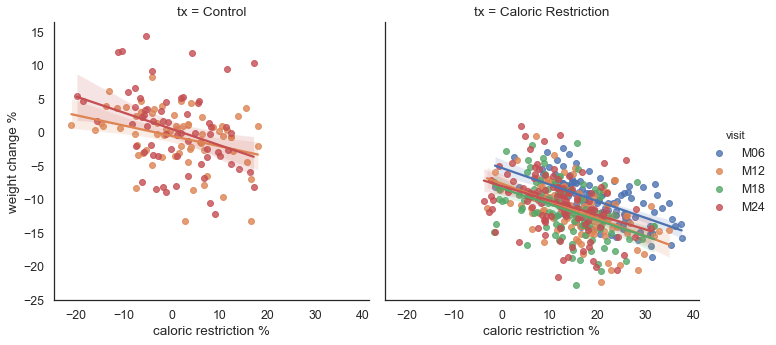

In [32]:
v='caloric restriction %'
o='weight change %'

# check robustness by getting rid of people who are >97.5%ile or <2.5%ile
dc = ddat[v].quantile(0.025)
todrop1 = ddat.index[ ddat[v]<dc ].to_series()
dc = ddat[v].quantile(0.975)
todrop2 = ddat.index[ ddat[v]>dc ].to_series()
todrop = pd.concat([todrop1, todrop2])
# or don't if this is uncommented below (eliminates todrop)
todrop=[]

print('Out of {} datapoints, dropping {}'.format( len(ddat), len(todrop)) )
ll = ddat.drop(todrop).reset_index()
            
# remove problem characters from variable names to make LMER style formulas work
ny = o.replace(' ','_').replace('%','pct')
nx = v.replace(' ','_').replace('%','pct')
ndat = ll.rename({o:ny, v:nx, 'caloric restriction %':'caloric_restriction_pct'},axis=1)
formula = '{} ~ {}  + tx + visit'.format(ny,nx)
print(formula)

model = ols(formula,ndat).fit()

h = sns.lmplot(data=ll, x=v, y=o, col='tx',
              hue='visit', hue_order=['M06','M12','M18','M24'])

sns.despine()
plt.savefig(outdir+nx+'_tx_visit_'+ny+'.png',dpi=300)

with open(outdir+'tab1_'+nx+'_tx_visit_'+ny+'.csv','w') as csvf:
    csvf.write(model.summary().as_csv())
    csvf.close()
    
res = anova_lm(model)
var_explained = (res['sum_sq']/res['sum_sq'].sum()).rename('Var explained')
results_summary = model.summary()
results_as_html = results_summary.tables[1].as_html()
output = pd.read_html(results_as_html, header=0, index_col=0)[0].join(var_explained, how='outer')
output.columns.name='Dependent var: '+model.model.endog_names
output = shift_row_to_bottom(output,1)
output.to_csv(outdir+'tab2_'+nx+'_tx_visit_'+ny+'.csv')

display(model.summary())
display(output)

Out of 587 datapoints, dropping 0
weight_change_pct ~ caloric_restriction_pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     407.8
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           3.35e-69
Time:                        15:42:03   Log-Likelihood:                -1744.9
No. Observations:                 587   AIC:                             3494.
Df Residuals:                     585   BIC:                             3503.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.8634      0.302    -12.797      0.000      -4.456      -3.270
caloric_restriction_pct    -0.3913      0.019    -20.193      0.000      -0.429      -0.353
==============================================================================
Omnibus:                       31.123   Durbin-Watson:                   0.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.491
Skew:                           0.437   Prob(JB):                     2.18e-10
Kurtosis:                       4.028   Cond. No.                         24.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: weight_change_pct,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-3.8634,0.302,-12.797,0.0,-4.456,-3.270,NaN
caloric_restriction_pct,-0.3913,0.019,-20.193,0.0,-0.429,-0.353,0.410738
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.589262


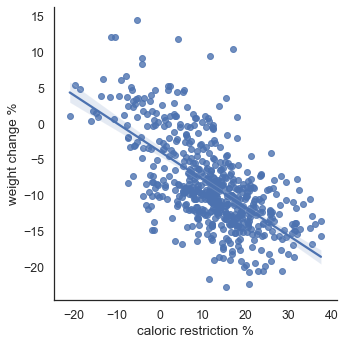

In [33]:
v='caloric restriction %'
o='weight change %'

# check robustness by getting rid of people who are >97.5%ile or <2.5%ile
dc = ddat[v].quantile(0.025)
todrop1 = ddat.index[ ddat[v]<dc ].to_series()
dc = ddat[v].quantile(0.975)
todrop2 = ddat.index[ ddat[v]>dc ].to_series()
todrop = pd.concat([todrop1, todrop2])
# or don't if this is uncommented below (eliminates todrop)
todrop=[]

print('Out of {} datapoints, dropping {}'.format( len(ddat), len(todrop)) )
ll = ddat.drop(todrop).reset_index()
            
# remove problem characters from variable names to make LMER style formulas work
ny = o.replace(' ','_').replace('%','pct')
nx = v.replace(' ','_').replace('%','pct')
ndat = ll.rename({o:ny, v:nx, 'caloric restriction %':'caloric_restriction_pct'},axis=1)
formula = '{} ~ {}'.format(ny,nx)
print(formula)

model = ols(formula,ndat).fit()

h = sns.lmplot(data=ll, x=v, y=o)

sns.despine()
plt.savefig(outdir+nx+'_'+ny+'.png',dpi=300)

with open(outdir+'tab1_'+nx+'_'+ny+'.csv','w') as csvf:
    csvf.write(model.summary().as_csv())
    csvf.close()
    
res = anova_lm(model)
var_explained = (res['sum_sq']/res['sum_sq'].sum()).rename('Var explained')
results_summary = model.summary()
results_as_html = results_summary.tables[1].as_html()
output = pd.read_html(results_as_html, header=0, index_col=0)[0].join(var_explained, how='outer')
output.columns.name='Dependent var: '+model.model.endog_names
output = shift_row_to_bottom(output,1)
output.to_csv(outdir+'tab2_'+nx+'_'+ny+'.csv')

display(model.summary())
display(output)


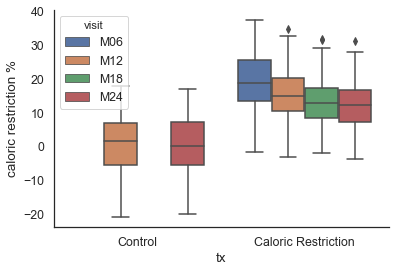

In [34]:
sns.boxplot(data=ddat.reset_index(), x='tx', y='caloric restriction %', hue='visit', hue_order=['M06','M12','M18','M24']);
sns.despine()
plt.savefig(outdir+'boxplot_caloric_restriction_pct_tx_visit.png',dpi=300)

In [35]:
from scipy import stats

g1 = ddat.query('tx=="Caloric Restriction" and visit=="M06"')['caloric restriction %']
g2 = ddat.query('tx=="Caloric Restriction" and visit=="M12"')['caloric restriction %']
g3 = ddat.query('tx=="Caloric Restriction" and visit=="M18"')['caloric restriction %']
g4 = ddat.query('tx=="Caloric Restriction" and visit=="M24"')['caloric restriction %']

stats.f_oneway(g1,g2,g3,g4)

F_onewayResult(statistic=24.29563238362748, pvalue=1.382110390377577e-14)

In [36]:
from scipy import stats

g2 = ddat.query('tx=="Control" and visit=="M12"')['caloric restriction %']
g4 = ddat.query('tx=="Control" and visit=="M24"')['caloric restriction %']

stats.f_oneway(g2,g4)

F_onewayResult(statistic=0.09404615419685448, pvalue=0.7595782014701393)

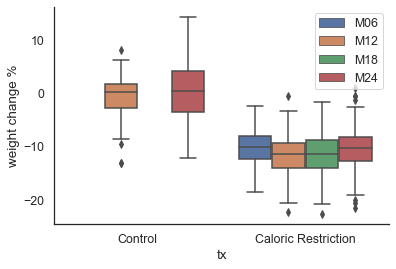

In [37]:
sns.boxplot(data=ddat.reset_index(), x='tx', y='weight change %', hue='visit', hue_order=['M06','M12','M18','M24'])
plt.legend(loc='upper right')
sns.despine()
plt.savefig(outdir+'boxplot_weight_change_pct_tx_visit.png',dpi=300)

In [38]:
from scipy import stats

g1 = ddat.query('tx=="Caloric Restriction" and visit=="M06"')['weight change %']
g2 = ddat.query('tx=="Caloric Restriction" and visit=="M12"')['weight change %']
g3 = ddat.query('tx=="Caloric Restriction" and visit=="M18"')['weight change %']
g4 = ddat.query('tx=="Caloric Restriction" and visit=="M24"')['weight change %']

stats.f_oneway(g1,g2,g3,g4)

F_onewayResult(statistic=3.808150570894618, pvalue=0.010237588050248778)

In [39]:
from scipy import stats

g2 = ddat.query('tx=="Control" and visit=="M12"')['weight change %']
g4 = ddat.query('tx=="Control" and visit=="M24"')['weight change %']

stats.f_oneway(g2,g4)

F_onewayResult(statistic=1.4098736407178991, pvalue=0.23720969800473996)

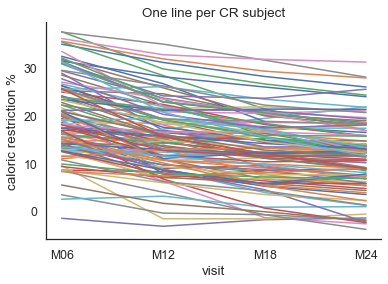

In [40]:
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['caloric restriction %'].plot();
plt.xticks([0,1,2,3],['M06','M12','M18','M24'])
plt.ylabel('caloric restriction %');
plt.xlabel('visit');
plt.title('One line per CR subject')
sns.despine()
plt.savefig(outdir+'lineplot_caloric_restriction_visit.png',dpi=300)

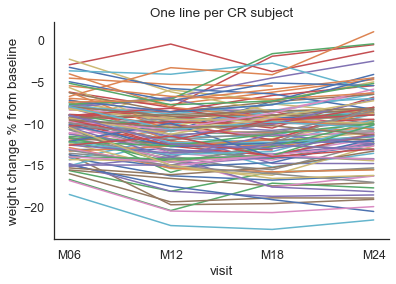

In [41]:

ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['weight change %'].plot();
plt.xticks([0,1,2,3],['M06','M12','M18','M24'])
plt.ylabel('weight change % from baseline');
plt.xlabel('visit');
plt.title('One line per CR subject')
sns.despine()
plt.savefig(outdir+'lineplot_weight_change_visit.png',dpi=300)

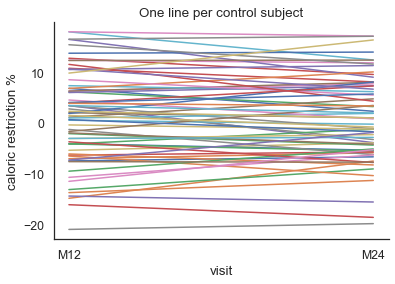

In [42]:
ddat.query('tx=="Control"').groupby('deidnum')['caloric restriction %'].plot();
plt.xticks([0,1],['M12','M24'])
plt.ylabel('caloric restriction %');
plt.xlabel('visit');
plt.title('One line per control subject')
sns.despine()
plt.savefig(outdir+'lineplot_control_caloric_restriction_visit.png',dpi=300)

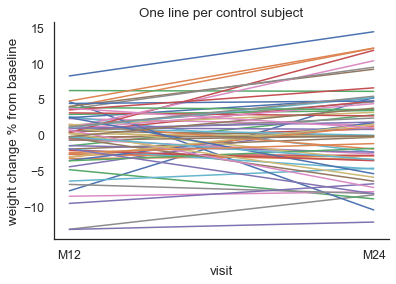

In [43]:
ddat.query('tx=="Control"').groupby('deidnum')['weight change %'].plot();
plt.xticks([0,1],['M12','M24'])
plt.ylabel('weight change % from baseline');
plt.xlabel('visit');
plt.title('One line per control subject')
sns.despine()
plt.savefig(outdir+'lineplot_control_weight_change_visit.png',dpi=300)

In [44]:
ddat.query('tx=="Caloric Restriction"').groupby('visit')['caloric restriction %'].describe()

,count,mean,std,min,25%,50%,75%,max
visit,,,,,,,,
M06,115.0,19.753249,8.095437,-1.495537,13.539355,18.895334,25.526688,37.534185
M12,113.0,15.384784,7.350051,-3.166077,10.631581,15.101076,20.249371,34.941673
M18,113.0,13.181001,7.116540,-1.789186,8.566621,12.777635,17.415332,31.766832
M24,112.0,11.904097,7.235733,-3.823047,7.408733,12.156824,16.817175,31.188925


In [45]:
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['caloric restriction %'].mean().describe()

count    115.000000
mean      15.110419
std        7.084475
min       -1.971239
25%       10.236652
50%       14.468146
75%       19.882697
max       33.008332
Name: caloric restriction %, dtype: float64

In [46]:
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['caloric restriction %'].std().describe()

count    114.000000
mean       3.768853
std        2.202670
min        0.238367
25%        1.921356
50%        3.417967
75%        5.418661
max        8.996139
Name: caloric restriction %, dtype: float64

In [47]:
ddat.query('tx=="Caloric Restriction"').groupby('visit')['weight change %'].describe()

,count,mean,std,min,25%,50%,75%,max
visit,,,,,,,,
M06,115.0,-10.202161,3.225288,-18.552465,-12.274380,-10.054381,-8.080088,-2.279921
M12,113.0,-11.651119,3.703071,-22.292457,-14.035940,-11.338237,-9.268770,-0.464057
M18,113.0,-11.483277,4.038081,-22.756005,-14.001729,-11.405611,-8.772904,-1.620491
M24,112.0,-10.568433,4.304426,-21.618205,-12.715108,-10.211118,-8.292387,1.018634


In [48]:
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['weight change %'].mean().describe()

count    115.000000
mean     -10.980631
std        3.585013
min      -21.304783
25%      -13.063832
50%      -10.936826
75%       -8.790600
max       -2.130396
Name: weight change %, dtype: float64

In [49]:
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['weight change %'].std().describe()

count    114.000000
mean       1.507231
std        0.762967
min        0.271150
25%        0.930537
50%        1.494157
75%        1.979203
max        3.724231
Name: weight change %, dtype: float64

,minimum CR% quantiles
0.10,2.175492
0.20,5.832436
0.25,6.994041
0.30,8.116050
0.40,10.807599
0.50,11.649723
0.60,13.003301
0.70,14.691868
0.75,15.717224
0.80,17.176404


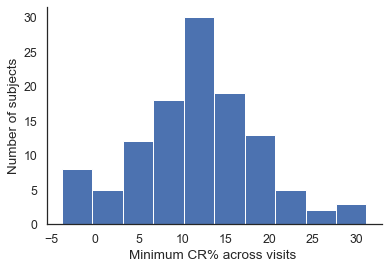

In [50]:
# how many CR participants maintained at least so much CR throughout the study?
sns.set_style('white')
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['caloric restriction %'].min().hist();
plt.grid(False)
sns.despine()
plt.ylabel('Number of subjects')
plt.xlabel('Minimum CR% across visits ');
( ddat.query('tx=="Caloric Restriction"')
 .groupby('deidnum')['caloric restriction %'].min()
 .quantile([.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9])
 .rename('minimum CR% quantiles').to_frame() )

,mean CR% quantiles
0.10,7.334057
0.20,9.145098
0.25,10.236652
0.30,11.727196
0.40,12.960487
0.50,14.468146
0.60,16.789828
0.70,18.572758
0.75,19.882697
0.80,20.828193


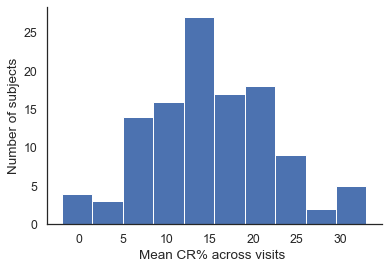

In [51]:
# how many CR participants maintained an average of so much CR throughout the study?
sns.set_style('white')
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['caloric restriction %'].mean().hist();
plt.grid(False)
sns.despine()
plt.ylabel('Number of subjects')
plt.xlabel('Mean CR% across visits ');
( ddat.query('tx=="Caloric Restriction"')
 .groupby('deidnum')['caloric restriction %'].mean()
 .quantile([.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9])
 .rename('mean CR% quantiles').to_frame() )

,mean wt change % quantiles
0.10,-15.244859
0.20,-13.725707
0.25,-13.063832
0.30,-12.648973
0.40,-11.823910
0.50,-10.936826
0.60,-9.865148
0.70,-8.997114
0.75,-8.790600
0.80,-8.378606


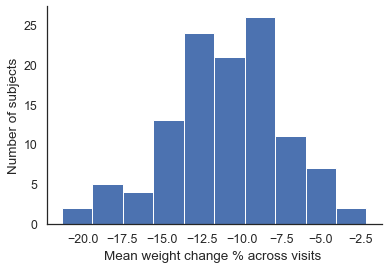

In [52]:
# how many CR participants maintained an average of so much CR throughout the study?
sns.set_style('white')
ddat.query('tx=="Caloric Restriction"').groupby('deidnum')['weight change %'].mean().hist();
plt.grid(False)
sns.despine()
plt.ylabel('Number of subjects')
plt.xlabel('Mean weight change % across visits ');
( ddat.query('tx=="Caloric Restriction"')
 .groupby('deidnum')['weight change %'].mean()
 .quantile([.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9])
 .rename('mean wt change % quantiles').to_frame() )

# The main linear analysis

Let's use linear models to show potential associations between eating pattern variables and weight loss after controlling for the known influence of caloric restriction on weight loss. The fits are of the form:

### Model M1
$$  \mathrm{delta\_weight\%} =  C_1 \times \mathrm{eating\_pattern\_variable}  +  C_2 \times \mathrm{caloric\_restriction\%}  + C_3 \times (\mathrm{eating\_pattern\_variable} \times \mathrm{caloric\_restriction\%}) + C_4$$

We have not controlled for gender here… and generally I see little effect or negative impact on model fit when I try. It's also useful to note that 69% of subjects are female in the datasets.

We have not controlled for treatment/control here… because our assumption is that CR is what matters for weight loss as the default it wouldn’t matter which group someone was placed in theoretically.

### Model M2
$$  \mathrm{delta\_weight\%} =  C_1 \times \mathrm{eating\_pattern\_variable}  +  C_2 $$

### Model M3
$$  \mathrm{caloric\_restriction\%} =  C_1 \times \mathrm{eating\_pattern\_variable}  +  C_2 $$

 M2 and M3 provide a point of comparison for M1, and may suggest if the relationship of eating pattern variable and weight change is direct, or mediated indirectly through a relationship with caloric restriction.
 
 Again I have not controlled for gender here and generally see little or no difference when I do.  And for M2 if I include additive terms for tx and visit then the main effects of the variable of interest does not generally change but the r2 of the whole model becomes much much better for obvious reasons (they are surrogates for CR%)
 

In [53]:
          
# useful to group things by tercile or quartile when plotting, 
# in order to visualize the effects of CR on our variable of interest when trying to understand M1
pctcr3 = add_grouping_ignore_visit(ddat.copy(), 'caloric restriction %')['caloric restriction % grouping']
pctcr4 = add_quartile_ignore_visit(ddat.copy(), 'caloric restriction %')['caloric restriction % grouping']
ddat['CR% terciles']=pctcr3
ddat['CR% quartiles']=pctcr4

In [54]:
# how many data points from each treatment are in the various terciles of Caloric Restriction
ddat.groupby(['CR% terciles','tx'])['tx'].count().unstack().loc[['low','mid','high']]

tx,Caloric Restriction,Control
CR% terciles,,
low,87,107
mid,173,20
high,193,7


In [55]:
# what's the CR% range in the terciles 
ddat.groupby(['CR% terciles'])['caloric restriction %'].describe().loc[['low','mid','high']]

,count,mean,std,min,25%,50%,75%,max
CR% terciles,,,,,,,,
low,194.0,0.721203,6.397183,-20.971252,-3.049491,2.009182,6.169277,8.548946
mid,193.0,12.347649,1.995741,8.564389,11.018774,12.427833,13.820664,15.848040
high,200.0,22.227746,5.237894,15.853392,18.111186,20.767021,25.526671,37.534185


In [56]:
# how many data points from each treatment are in the various quartiles of Caloric Restriction
ddat.groupby(['CR% quartiles','tx'])['tx'].count().unstack()

tx,Caloric Restriction,Control
CR% quartiles,,
1st quartile,53.0,94.0
2nd quartile,119.0,28.0
3rd quartile,134.0,12.0
4th quartile,147.0,NaN


In [57]:
# what's the CR% range in the terciles 
ddat.groupby(['CR% quartiles'])['caloric restriction %'].describe()

,count,mean,std,min,25%,50%,75%,max
CR% quartiles,,,,,,,,
1st quartile,147.0,-1.410052,5.922858,-20.971252,-4.727385,-0.752786,3.449682,6.187746
2nd quartile,147.0,9.692041,1.926174,6.198955,8.037945,9.722603,11.570019,12.497582
3rd quartile,146.0,15.124417,1.712003,12.532341,13.473481,15.151440,16.562015,18.186542
4th quartile,147.0,24.101644,4.886862,18.200303,20.367236,22.828388,26.641968,37.534185


# 95%tile eating interval

In [58]:
# no difference among any tx : visit

g1 = ddat.query('tx=="Caloric Restriction" and visit=="M06"')['eating interval mid 95%'].dropna()
g2 = ddat.query('tx=="Caloric Restriction" and visit=="M12"')['eating interval mid 95%'].dropna()
g3 = ddat.query('tx=="Caloric Restriction" and visit=="M18"')['eating interval mid 95%'].dropna()
g4 = ddat.query('tx=="Caloric Restriction" and visit=="M24"')['eating interval mid 95%'].dropna()
g5 = ddat.query('tx=="Control" and visit=="M12"')['eating interval mid 95%'].dropna()
g6 = ddat.query('tx=="Control" and visit=="M24"')['eating interval mid 95%'].dropna()


stats.f_oneway(g1,g2,g3,g4,g5,g6)

F_onewayResult(statistic=0.3617306259189935, pvalue=0.8746925231385628)

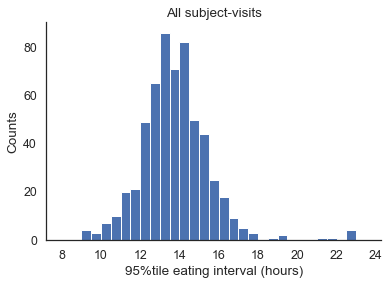

In [59]:
ddat['eating interval mid 95%'].hist(bins=np.arange(8.,24.,0.5))
plt.ylabel('Counts')
plt.xlabel('95%tile eating interval (hours)')
plt.title('All subject-visits')
plt.grid(False)
sns.despine()
plt.savefig(outdir+'hist_95pct_eating_interval_all.png',dpi=300)

In [60]:
ddat['eating interval mid 95%'].describe()

count    581.000000
mean      13.746356
std        1.758940
min        9.133333
25%       12.718750
50%       13.650000
75%       14.600000
max       22.812500
Name: eating interval mid 95%, dtype: float64

In [61]:
twelves = ddat['eating interval mid 95%']<12
tens = ddat['eating interval mid 95%']<10
print( twelves.sum(), ddat.loc[twelves].reset_index().deidnum.drop_duplicates().count())
print( tens.sum(), ddat.loc[tens].reset_index().deidnum.drop_duplicates().count())

65 41
7 6


In [62]:
ddat['eating interval mid 95%'].describe()

count    581.000000
mean      13.746356
std        1.758940
min        9.133333
25%       12.718750
50%       13.650000
75%       14.600000
max       22.812500
Name: eating interval mid 95%, dtype: float64

In [63]:
ddat['eating interval mid 95%'].describe()

count    581.000000
mean      13.746356
std        1.758940
min        9.133333
25%       12.718750
50%       13.650000
75%       14.600000
max       22.812500
Name: eating interval mid 95%, dtype: float64

Out of 587 datapoints, dropping 0
weight_change_pct ~ eating_interval_mid_95pct  * caloric_restriction_pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     140.1
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           3.32e-68
Time:                        15:42:09   Log-Likelihood:                -1717.5
No. Observations:                 581   AIC:                             3443.
Df Residuals:                     577   BIC:                             3460.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             1.3907      2.261      0.615      0.539      -3.050       5.832
eating_interval_mid_95pct                            -0.3811      0.161     -2.371      0.018      -0.697      -0.065
caloric_restriction_pct                              -0.6948      0.161     -4.326      0.000      -1.010      -0.379
eating_interval_mid_95pct:caloric_restriction_pct     0.0220      0.012      1.896      0.058      -0.001       0.045
==============================================================================
Omnibus:                       25.890   Durbin-Watson:                   0.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.847
Skew:                           0.390   Prob(JB):                     1.64e-08
Kurtosis:                       3.934   Cond. No.                     2.52e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,1.3907,2.261,0.615,0.539,-3.050,5.832,NaN
caloric_restriction_pct,-0.6948,0.161,-4.326,0.000,-1.010,-0.379,0.417638
eating_interval_mid_95pct,-0.3811,0.161,-2.371,0.018,-0.697,-0.065,0.000258
eating_interval_mid_95pct:caloric_restriction_pct,0.0220,0.012,1.896,0.058,-0.001,0.045,0.003604
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.578500


weight_change_pct ~ eating_interval_mid_95pct 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1497
Date:                Wed, 04 Aug 2021   Prob (F-statistic):              0.699
Time:                        15:42:09   Log-Likelihood:                -1876.4
No. Observations:                 581   AIC:                             3757.
Df Residuals:                     579   BIC:                             3766.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -9.3369      2.004     -4.659      0.000     -13.273      -5.401
eating_interval_mid_95pct     0.0559      0.145      0.387      0.699      -0.228       0.340
==============================================================================
Omnibus:                       51.113   Durbin-Watson:                   0.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.689
Skew:                           0.752   Prob(JB):                     2.44e-14
Kurtosis:                       3.571   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-9.3369,2.004,-4.659,0.000,-13.273,-5.401,NaN
eating_interval_mid_95pct,0.0559,0.145,0.387,0.699,-0.228,0.340,0.000258
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.999742


caloric_restriction_pct ~ eating_interval_mid_95pct 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     caloric_restriction_pct   R-squared:                       0.009
Model:                                 OLS   Adj. R-squared:                  0.007
Method:                      Least Squares   F-statistic:                     5.347
Date:                     Wed, 04 Aug 2021   Prob (F-statistic):             0.0211
Time:                             15:42:10   Log-Likelihood:                -2166.2
No. Observations:                      581   AIC:                             4336.
Df Residuals:                          579   BIC:                             4345.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    19.4803      3.300      5.904      0.000      13.000      25.961
eating_interval_mid_95pct    -0.5506      0.238     -2.312      0.021      -1.018      -0.083
==============================================================================
Omnibus:                        9.155   Durbin-Watson:                   0.628
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.192
Skew:                          -0.276   Prob(JB):                       0.0101
Kurtosis:                       3.274   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,19.4803,3.300,5.904,0.000,13.000,25.961,NaN
eating_interval_mid_95pct,-0.5506,0.238,-2.312,0.021,-1.018,-0.083,0.009151
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.990849


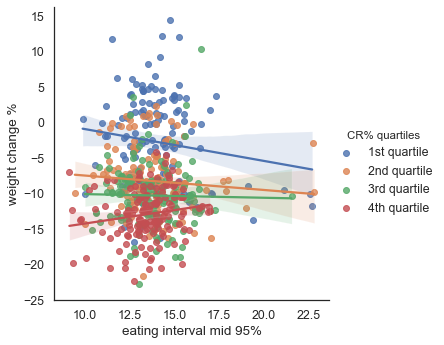

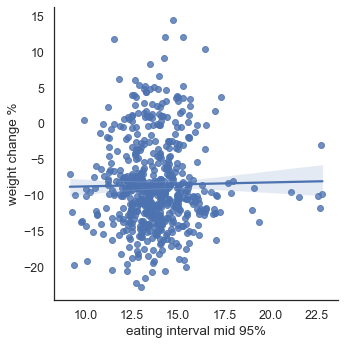

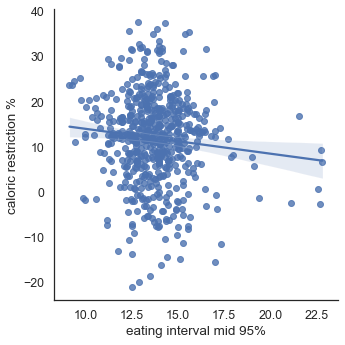

In [64]:
linear_models(ddat, 'eating interval mid 95%')

# Mean daily eating interval

In [65]:
# no difference among any tx : visit

g1 = ddat.query('tx=="Caloric Restriction" and visit=="M06"')['mean daily eating interval'].dropna()
g2 = ddat.query('tx=="Caloric Restriction" and visit=="M12"')['mean daily eating interval'].dropna()
g3 = ddat.query('tx=="Caloric Restriction" and visit=="M18"')['mean daily eating interval'].dropna()
g4 = ddat.query('tx=="Caloric Restriction" and visit=="M24"')['mean daily eating interval'].dropna()
g5 = ddat.query('tx=="Control" and visit=="M12"')['mean daily eating interval'].dropna()
g6 = ddat.query('tx=="Control" and visit=="M24"')['mean daily eating interval'].dropna()


stats.f_oneway(g1,g2,g3,g4,g5,g6)

F_onewayResult(statistic=1.5951288016452077, pvalue=0.1594918184185084)

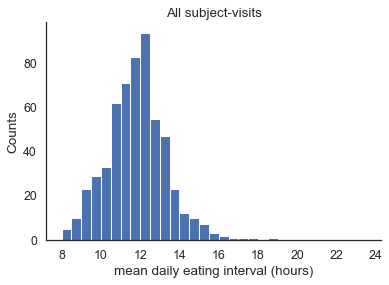

In [66]:
ddat['mean daily eating interval'].hist(bins=np.arange(8.,24.,0.5))
plt.ylabel('Counts')
plt.xlabel('mean daily eating interval (hours)')
plt.title('All subject-visits')
plt.grid(False)
sns.despine()
plt.savefig(outdir+'hist_meandaily_eating_interval_all.png',dpi=300)

In [67]:
ddat['mean daily eating interval'].describe()

count    581.000000
mean      11.722542
std        1.620413
min        5.916667
25%       10.833333
50%       11.750000
75%       12.652778
max       18.916667
Name: mean daily eating interval, dtype: float64

In [68]:
ddat['eating interval mid 95%'].describe()

count    581.000000
mean      13.746356
std        1.758940
min        9.133333
25%       12.718750
50%       13.650000
75%       14.600000
max       22.812500
Name: eating interval mid 95%, dtype: float64

Out of 587 datapoints, dropping 0
weight_change_pct ~ mean_daily_eating_interval  * caloric_restriction_pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     154.3
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           1.96e-73
Time:                        15:42:11   Log-Likelihood:                -1705.3
No. Observations:                 581   AIC:                             3419.
Df Residuals:                     577   BIC:                             3436.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              6.4742      1.922      3.369      0.001       2.699      10.249
mean_daily_eating_interval                            -0.8926      0.163     -5.473      0.000      -1.213      -0.572
caloric_restriction_pct                               -0.8169      0.134     -6.096      0.000      -1.080      -0.554
mean_daily_eating_interval:caloric_restriction_pct     0.0368      0.011      3.239      0.001       0.014       0.059
==============================================================================
Omnibus:                       27.862   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.980
Skew:                           0.401   Prob(JB):                     2.08e-09
Kurtosis:                       4.004   Cond. No.                     1.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,6.4742,1.922,3.369,0.001,2.699,10.249,NaN
caloric_restriction_pct,-0.8169,0.134,-6.096,0.000,-1.080,-0.554,0.409465
mean_daily_eating_interval,-0.8926,0.163,-5.473,0.000,-1.213,-0.572,0.025645
mean_daily_eating_interval:caloric_restriction_pct,0.0368,0.011,3.239,0.001,0.014,0.059,0.010089
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.554801


weight_change_pct ~ mean_daily_eating_interval 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     15.24
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           0.000106
Time:                        15:42:12   Log-Likelihood:                -1868.9
No. Observations:                 581   AIC:                             3742.
Df Residuals:                     579   BIC:                             3751.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.4771      1.834     -0.806      0.421      -5.079       2.124
mean_daily_eating_interval    -0.6049      0.155     -3.904      0.000      -0.909      -0.301
==============================================================================
Omnibus:                       46.019   Durbin-Watson:                   0.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.276
Skew:                           0.703   Prob(JB):                     9.93e-13
Kurtosis:                       3.552   Cond. No.                         87.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-1.4771,1.834,-0.806,0.421,-5.079,2.124,NaN
mean_daily_eating_interval,-0.6049,0.155,-3.904,0.000,-0.909,-0.301,0.025645
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.974355


caloric_restriction_pct ~ mean_daily_eating_interval 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     caloric_restriction_pct   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                 -0.001
Method:                      Least Squares   F-statistic:                    0.6291
Date:                     Wed, 04 Aug 2021   Prob (F-statistic):              0.428
Time:                             15:42:12   Log-Likelihood:                -2168.5
No. Observations:                      581   AIC:                             4341.
Df Residuals:                          579   BIC:                             4350.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.4992      3.071      3.093      0.002       3.468      15.531
mean_daily_eating_interval     0.2058      0.259      0.793      0.428      -0.304       0.715
==============================================================================
Omnibus:                        8.581   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.514
Skew:                          -0.276   Prob(JB):                       0.0142
Kurtosis:                       3.218   Cond. No.                         87.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,9.4992,3.071,3.093,0.002,3.468,15.531,NaN
mean_daily_eating_interval,0.2058,0.259,0.793,0.428,-0.304,0.715,0.001085
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.998915


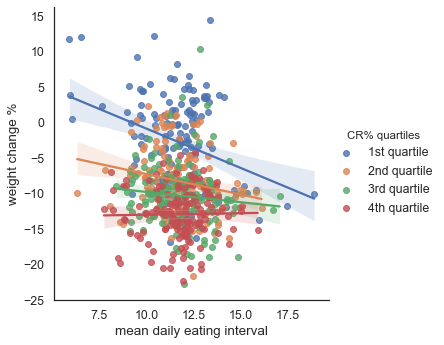

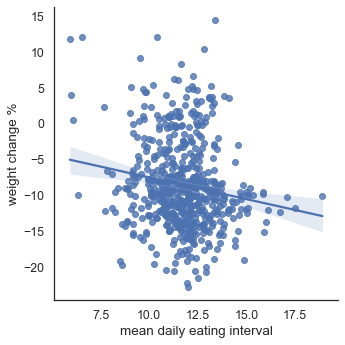

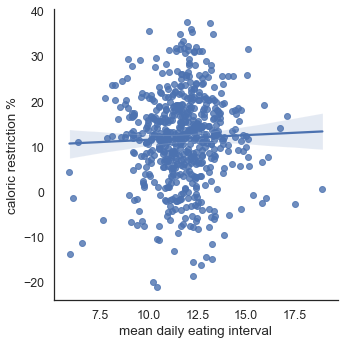

In [69]:
linear_models(ddat, 'mean daily eating interval')

# First meal shift

count    581.000000
mean       1.039727
std        0.752697
min        0.000000
25%        0.500000
50%        0.900000
75%        1.400000
max        6.383333
Name: mean firstmeal shift, dtype: float64

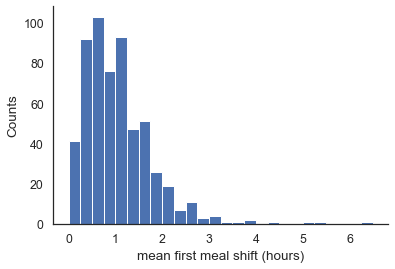

In [70]:
sns.set_style('white')
ddat['mean firstmeal shift'].hist(bins=np.arange(0,6.75,0.25))
plt.grid(False)
sns.despine()
plt.ylabel('Counts')
plt.xlabel('mean first meal shift (hours)')
sns.despine()
plt.savefig(outdir+'hist_mean_firstmeal_shift.png',dpi=300)
ddat['mean firstmeal shift'].describe()

,count,mean,std,min,25%,50%,75%,max
tx,,,,,,,,
Caloric Restriction,450.0,0.964348,0.688866,0.000000,0.404167,0.808333,1.30,5.400000
Control,131.0,1.298664,0.895257,0.156667,0.700000,1.100000,1.65,6.383333


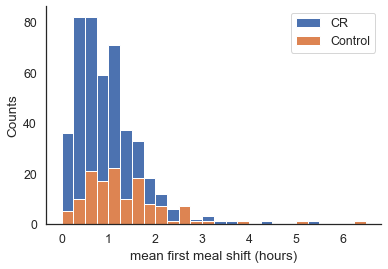

In [71]:
sns.set_style('white')
ddat.groupby('tx')['mean firstmeal shift'].hist(bins=np.arange(0,6.75,0.25))
plt.grid(False)
sns.despine()
plt.ylabel('Counts')
plt.xlabel('mean first meal shift (hours)')
plt.legend(['CR','Control'])
#plt.savefig(outdir+'hist_mean_firstmeal_shift.png',dpi=300)
ddat.groupby('tx')['mean firstmeal shift'].describe()

In [72]:
# no difference among any tx : visit

g1 = ddat.query('tx=="Caloric Restriction" and visit=="M06"')['mean firstmeal shift'].dropna()
g2 = ddat.query('tx=="Caloric Restriction" and visit=="M12"')['mean firstmeal shift'].dropna()
g3 = ddat.query('tx=="Caloric Restriction" and visit=="M18"')['mean firstmeal shift'].dropna()
g4 = ddat.query('tx=="Caloric Restriction" and visit=="M24"')['mean firstmeal shift'].dropna()
g5 = ddat.query('tx=="Control" and visit=="M12"')['mean firstmeal shift'].dropna()
g6 = ddat.query('tx=="Control" and visit=="M24"')['mean firstmeal shift'].dropna()


stats.f_oneway(g1,g2,g3,g4,g5,g6)

F_onewayResult(statistic=4.669521852921264, pvalue=0.0003457614567662947)

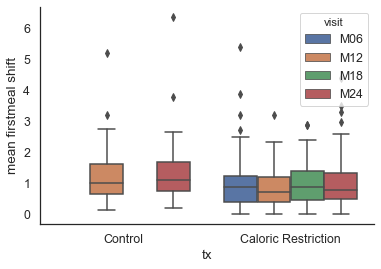

In [73]:
sns.boxplot(data=ddat.reset_index(), x='tx', y='mean firstmeal shift', hue='visit', hue_order=['M06','M12','M18','M24'] )
sns.despine()

In [74]:
groups = ddat.reset_index().tx + ddat.reset_index().visit
ddat['mcgroups']=groups.to_list()
mcdat = ddat.dropna(subset=['mean firstmeal shift'])

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)


# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison( mcdat['mean firstmeal shift'], 
                             mcdat['mcgroups'])
display(MultiComp.tukeyhsd().summary())

group1,group2,meandiff,p-adj,lower,upper,reject
Caloric RestrictionM06,Caloric RestrictionM12,-0.1362,0.7113,-0.4181,0.1458,False
Caloric RestrictionM06,Caloric RestrictionM18,-0.0265,0.9,-0.3072,0.2542,False
Caloric RestrictionM06,Caloric RestrictionM24,-0.0414,0.9,-0.3233,0.2406,False
Caloric RestrictionM06,ControlM12,0.2371,0.2982,-0.0885,0.5628,False
Caloric RestrictionM06,ControlM24,0.3328,0.0473,0.0023,0.6632,True
Caloric RestrictionM12,Caloric RestrictionM18,0.1097,0.869,-0.1735,0.3928,False
Caloric RestrictionM12,Caloric RestrictionM24,0.0948,0.9,-0.1896,0.3792,False
Caloric RestrictionM12,ControlM12,0.3733,0.0151,0.0455,0.7012,True
Caloric RestrictionM12,ControlM24,0.4689,0.001,0.1364,0.8015,True
Caloric RestrictionM18,Caloric RestrictionM24,-0.0149,0.9,-0.298,0.2683,False


Out of 587 datapoints, dropping 0
weight_change_pct ~ mean_firstmeal_shift  * caloric_restriction_pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     149.6
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           1.04e-71
Time:                        15:42:15   Log-Likelihood:                -1709.3
No. Observations:                 581   AIC:                             3427.
Df Residuals:                     577   BIC:                             3444.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -5.6334      0.492    -11.446      0.000      -6.600      -4.667
mean_firstmeal_shift                             1.4286      0.327      4.363      0.000       0.785       2.072
caloric_restriction_pct                         -0.3427      0.032    -10.804      0.000      -0.405      -0.280
mean_firstmeal_shift:caloric_restriction_pct    -0.0305      0.024     -1.280      0.201      -0.077       0.016
==============================================================================
Omnibus:                       21.124   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.730
Skew:                           0.349   Prob(JB):                     9.52e-07
Kurtosis:                       3.812   Cond. No.                         67.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-5.6334,0.492,-11.446,0.000,-6.600,-4.667,NaN
caloric_restriction_pct,-0.3427,0.032,-10.804,0.000,-0.405,-0.280,0.373558
mean_firstmeal_shift,1.4286,0.327,4.363,0.000,0.785,2.072,0.062341
mean_firstmeal_shift:caloric_restriction_pct,-0.0305,0.024,-1.280,0.201,-0.077,0.016,0.001596
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.562506


weight_change_pct ~ mean_firstmeal_shift 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     38.50
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           1.05e-09
Time:                        15:42:15   Log-Likelihood:                -1857.8
No. Observations:                 581   AIC:                             3720.
Df Residuals:                     579   BIC:                             3728.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -10.6790      0.420    -25.431      0.000     -11.504      -9.854
mean_firstmeal_shift     2.0303      0.327      6.204      0.000       1.388       2.673
==============================================================================
Omnibus:                       42.655   Durbin-Watson:                   0.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.096
Skew:                           0.704   Prob(JB):                     1.32e-11
Kurtosis:                       3.298   Cond. No.                         3.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-10.6790,0.420,-25.431,0.0,-11.504,-9.854,NaN
mean_firstmeal_shift,2.0303,0.327,6.204,0.0,1.388,2.673,0.062341
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.937659


caloric_restriction_pct ~ mean_firstmeal_shift 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     caloric_restriction_pct   R-squared:                       0.029
Model:                                 OLS   Adj. R-squared:                  0.027
Method:                      Least Squares   F-statistic:                     17.35
Date:                     Wed, 04 Aug 2021   Prob (F-statistic):           3.59e-05
Time:                             15:42:16   Log-Likelihood:                -2160.3
No. Observations:                      581   AIC:                             4325.
Df Residuals:                          579   BIC:                             4333.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               14.2970      0.707     20.230      0.000      12.909      15.685
mean_firstmeal_shift    -2.2939      0.551     -4.165      0.000      -3.376      -1.212
==============================================================================
Omnibus:                        8.496   Durbin-Watson:                   0.666
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.494
Skew:                          -0.264   Prob(JB):                       0.0143
Kurtosis:                       3.268   Cond. No.                         3.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,14.2970,0.707,20.230,0.0,12.909,15.685,NaN
mean_firstmeal_shift,-2.2939,0.551,-4.165,0.0,-3.376,-1.212,0.029089
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.970911


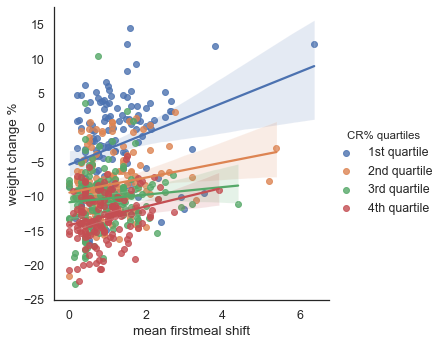

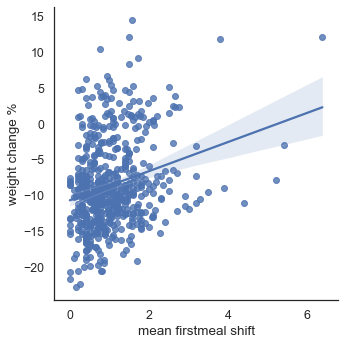

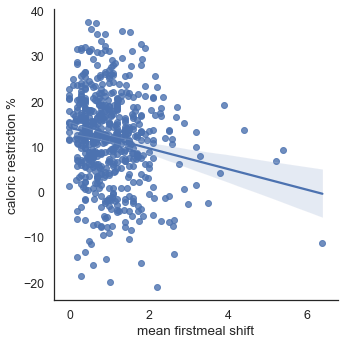

In [75]:
linear_models(ddat, 'mean firstmeal shift')

## The statistics of last meal shift

count    581.000000
mean       1.534530
std        0.900253
min        0.000000
25%        0.900000
50%        1.350000
75%        2.000000
max        6.000000
Name: mean lastmeal shift, dtype: float64

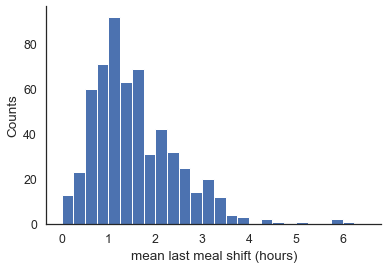

In [76]:
sns.set_style('white')
ddat['mean lastmeal shift'].hist(bins=np.arange(0,6.75,0.25))
plt.grid(False)
sns.despine()
plt.ylabel('Counts')
plt.xlabel('mean last meal shift (hours)')
sns.despine()
plt.savefig(outdir+'hist_mean_lastmeal_shift.png',dpi=300)
ddat['mean lastmeal shift'].describe()

In [77]:
# no difference among any tx : visit

g1 = ddat.query('tx=="Caloric Restriction" and visit=="M06"')['mean lastmeal shift'].dropna()
g2 = ddat.query('tx=="Caloric Restriction" and visit=="M12"')['mean lastmeal shift'].dropna()
g3 = ddat.query('tx=="Caloric Restriction" and visit=="M18"')['mean lastmeal shift'].dropna()
g4 = ddat.query('tx=="Caloric Restriction" and visit=="M24"')['mean lastmeal shift'].dropna()
g5 = ddat.query('tx=="Control" and visit=="M12"')['mean lastmeal shift'].dropna()
g6 = ddat.query('tx=="Control" and visit=="M24"')['mean lastmeal shift'].dropna()


stats.f_oneway(g1,g2,g3,g4,g5,g6)

F_onewayResult(statistic=1.3436117745926832, pvalue=0.24420751091029697)

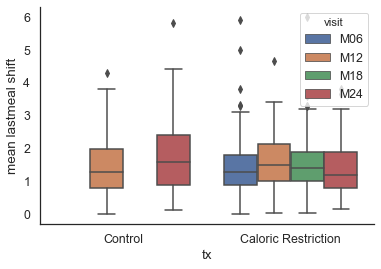

In [78]:
sns.boxplot(data=ddat.reset_index(), x='tx', y='mean lastmeal shift', hue='visit', hue_order=['M06','M12','M18','M24'] )
sns.despine()

In [79]:
groups = ddat.reset_index().tx + ddat.reset_index().visit
ddat['mcgroups']=groups.to_list()
mcdat = ddat.dropna(subset=['mean firstmeal shift'])

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)


# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison( mcdat['mean firstmeal shift'], 
                             mcdat['mcgroups'])
display(MultiComp.tukeyhsd().summary())

group1,group2,meandiff,p-adj,lower,upper,reject
Caloric RestrictionM06,Caloric RestrictionM12,-0.1362,0.7113,-0.4181,0.1458,False
Caloric RestrictionM06,Caloric RestrictionM18,-0.0265,0.9,-0.3072,0.2542,False
Caloric RestrictionM06,Caloric RestrictionM24,-0.0414,0.9,-0.3233,0.2406,False
Caloric RestrictionM06,ControlM12,0.2371,0.2982,-0.0885,0.5628,False
Caloric RestrictionM06,ControlM24,0.3328,0.0473,0.0023,0.6632,True
Caloric RestrictionM12,Caloric RestrictionM18,0.1097,0.869,-0.1735,0.3928,False
Caloric RestrictionM12,Caloric RestrictionM24,0.0948,0.9,-0.1896,0.3792,False
Caloric RestrictionM12,ControlM12,0.3733,0.0151,0.0455,0.7012,True
Caloric RestrictionM12,ControlM24,0.4689,0.001,0.1364,0.8015,True
Caloric RestrictionM18,Caloric RestrictionM24,-0.0149,0.9,-0.298,0.2683,False


Out of 587 datapoints, dropping 0
weight_change_pct ~ mean_lastmeal_shift  * caloric_restriction_pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     139.6
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           5.39e-68
Time:                        15:42:18   Log-Likelihood:                -1718.0
No. Observations:                 581   AIC:                             3444.
Df Residuals:                     577   BIC:                             3461.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -4.9262      0.568     -8.672      0.000      -6.042      -3.811
mean_lastmeal_shift                             0.6014      0.291      2.069      0.039       0.031       1.172
caloric_restriction_pct                        -0.3288      0.037     -8.902      0.000      -0.401      -0.256
mean_lastmeal_shift:caloric_restriction_pct    -0.0374      0.020     -1.867      0.062      -0.077       0.002
==============================================================================
Omnibus:                       23.720   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.584
Skew:                           0.377   Prob(JB):                     1.39e-07
Kurtosis:                       3.858   Cond. No.                         96.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-4.9262,0.568,-8.672,0.000,-6.042,-3.811,NaN
caloric_restriction_pct,-0.3288,0.037,-8.902,0.000,-0.401,-0.256,0.406757
mean_lastmeal_shift,0.6014,0.291,2.069,0.039,0.031,1.172,0.010268
mean_lastmeal_shift:caloric_restriction_pct,-0.0374,0.020,-1.867,0.062,-0.077,0.002,0.003502
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.579474


weight_change_pct ~ mean_lastmeal_shift 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.007
Date:                Wed, 04 Aug 2021   Prob (F-statistic):             0.0145
Time:                        15:42:18   Log-Likelihood:                -1873.5
No. Observations:                 581   AIC:                             3751.
Df Residuals:                     579   BIC:                             3760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -9.6251      0.500    -19.251      0.000     -10.607      -8.643
mean_lastmeal_shift     0.6889      0.281      2.451      0.015       0.137       1.241
==============================================================================
Omnibus:                       48.528   Durbin-Watson:                   0.486
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.552
Skew:                           0.740   Prob(JB):                     1.93e-13
Kurtosis:                       3.475   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-9.6251,0.500,-19.251,0.000,-10.607,-8.643,NaN
mean_lastmeal_shift,0.6889,0.281,2.451,0.015,0.137,1.241,0.010268
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.989732


caloric_restriction_pct ~ mean_lastmeal_shift 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     caloric_restriction_pct   R-squared:                       0.011
Model:                                 OLS   Adj. R-squared:                  0.009
Method:                      Least Squares   F-statistic:                     6.220
Date:                     Wed, 04 Aug 2021   Prob (F-statistic):             0.0129
Time:                             15:42:19   Log-Likelihood:                -2165.7
No. Observations:                      581   AIC:                             4335.
Df Residuals:                          579   BIC:                             4344.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.6910      0.827     16.559      0.000      12.067      15.315
mean_lastmeal_shift    -1.1593      0.465     -2.494      0.013      -2.072      -0.246
==============================================================================
Omnibus:                        7.993   Durbin-Watson:                   0.628
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.894
Skew:                          -0.266   Prob(JB):                       0.0193
Kurtosis:                       3.208   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,13.6910,0.827,16.559,0.000,12.067,15.315,NaN
mean_lastmeal_shift,-1.1593,0.465,-2.494,0.013,-2.072,-0.246,0.010628
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.989372


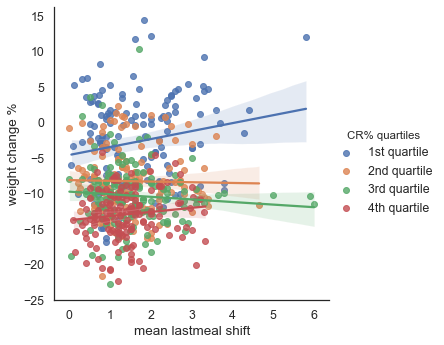

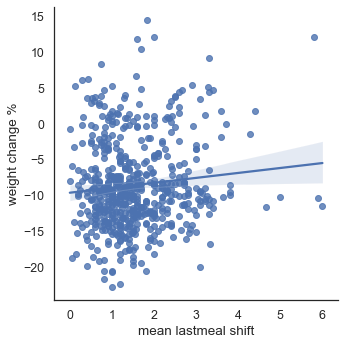

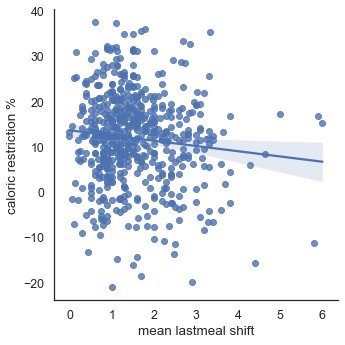

In [80]:
linear_models(ddat, 'mean lastmeal shift')

# Time to 50%tile calories

In [81]:
# for some reason there's a few entries that end up being strings, and one that is ' '                
those = meals.KCAL.apply( lambda x: not isinstance( x, float) )
for x in meals.loc[those,'KCAL']:
    try: 
        float(x)
    except:
        print("BAM!! found one.", x, type(x), x==' ')

        
def fixit(x):
    if not isinstance( x, float):
        try:
            float(x)
            return float(x)
        except: 
            return 0.0
    else:
        return x
    
meals.KCAL = meals.KCAL.apply( lambda x: fixit(x))

In [82]:
by_subj = meals.groupby(['deidnum','tx','condition']).apply( lambda x: percent_kcal_by_hour(x) )

mbs = by_subj.reset_index().groupby(['tx','condition']).mean().drop('deidnum',axis=1)

In [83]:
# you can see here that the mean/median time to 50%cal across everyone are both 15:30
# and the mean/median time to 95%cal is 21:30/21:00
# we will use these times to plot indicators below
by_subj.mean().rename('mean CDF').to_frame().join( by_subj.median().rename('median CDF'))

,mean CDF,median CDF
4.5,0.000368,0.000000
5.0,0.000752,0.000000
5.5,0.002669,0.000000
6.0,0.005817,0.000000
6.5,0.012241,0.000000
7.0,0.022004,0.005289
7.5,0.044853,0.026019
8.0,0.064331,0.052398
8.5,0.095997,0.094775
9.0,0.116526,0.115045


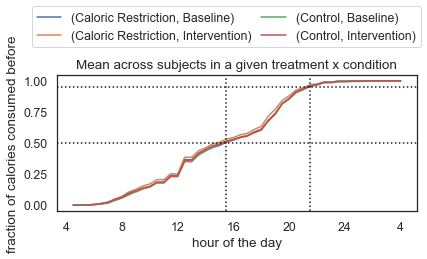

In [84]:
mbs.T.plot();
plt.xlabel('hour of the day')
plt.ylabel('fraction of calories consumed before')
plt.title('Mean across subjects in a given treatment x condition');

plt.xticks(np.arange(4,29,4),[4,8,12,16,20,24,4])
plt.axvline(x=15.5,linestyle=':',color='k')
plt.axvline(x=21.5,linestyle=':',color='k');

plt.axhline(y=0.5,linestyle=':',color='k')
plt.axhline(y=0.95,linestyle=':',color='k')
plt.legend(bbox_to_anchor=(-0.07, 1.2, 1.08, .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.);
plt.tight_layout()
#sns.despine()
plt.savefig(outdir+'mean_cal_CDF_across_subjects_by_treatment_condition.png',dpi=300)

In [85]:
from scipy.stats import ks_2samp

gnames = mbs.index.values
for x in range(0,4):
    for y in range (x+1,4):
        print (gnames[x], gnames[y], ks_2samp( mbs.iloc[x,:], mbs.iloc[y,:]) )

('Caloric Restriction', 'Baseline') ('Caloric Restriction', 'Intervention') Ks_2sampResult(statistic=0.0625, pvalue=0.9999917362742914)
('Caloric Restriction', 'Baseline') ('Control', 'Baseline') Ks_2sampResult(statistic=0.125, pvalue=0.85283384171513)
('Caloric Restriction', 'Baseline') ('Control', 'Intervention') Ks_2sampResult(statistic=0.10416666666666667, pvalue=0.9601715180757678)
('Caloric Restriction', 'Intervention') ('Control', 'Baseline') Ks_2sampResult(statistic=0.08333333333333333, pvalue=0.9969212833348372)
('Caloric Restriction', 'Intervention') ('Control', 'Intervention') Ks_2sampResult(statistic=0.08333333333333333, pvalue=0.9969212833348372)
('Control', 'Baseline') ('Control', 'Intervention') Ks_2sampResult(statistic=0.0625, pvalue=0.9999917362742914)


The above shows no evidence that there is any difference between the caloric CDF of different groups or conditions.  But there is considerable variation between individuals as you can see below, where one line is drawn for each subjectxcondition

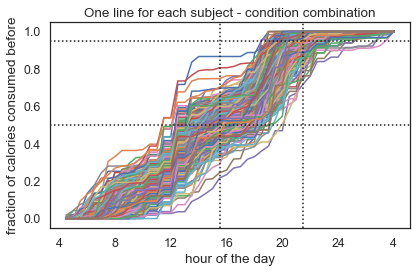

In [86]:
by_subj.T.plot(legend=None)
plt.xlabel('hour of the day')
plt.ylabel('fraction of calories consumed before')
plt.title('One line for each subject - condition combination');


plt.xticks(np.arange(4,29,4),[4,8,12,16,20,24,4])
plt.axvline(x=15.5,linestyle=':',color='k')
plt.axvline(x=21.5,linestyle=':',color='k');

plt.axhline(y=0.5,linestyle=':',color='k')
plt.axhline(y=0.95,linestyle=':',color='k');
plt.tight_layout()
#sns.despine()
plt.savefig(outdir+'mean_cal_CDF_per_subject_condition.png',dpi=300)

count    581.000000
mean      15.367470
std        2.052036
min       11.500000
25%       13.500000
50%       15.000000
75%       17.000000
max       20.500000
Name: time of 50% calories, dtype: float64

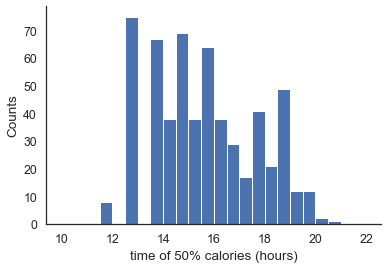

In [87]:
sns.set_style('white')
ddat['time of 50% calories'].hist(bins=np.arange(10,22.5,0.5))
plt.grid(False)
sns.despine()
plt.ylabel('Counts')
plt.xlabel('time of 50% calories (hours)')
plt.savefig(outdir+'hist_time_of_50% calories.png',dpi=300)
ddat['time of 50% calories'].describe()

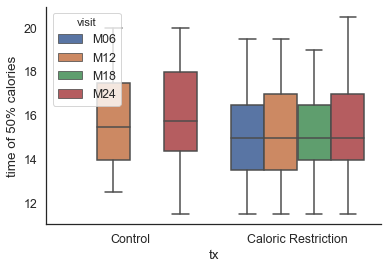

In [88]:
sns.boxplot(data=ddat.reset_index(), x='tx', y='time of 50% calories', hue='visit', hue_order=['M06','M12','M18','M24'], )
sns.despine()

In [89]:
# no difference among any tx : visit

g1 = ddat.query('tx=="Caloric Restriction" and visit=="M06"')['time of 50% calories'].dropna()
g2 = ddat.query('tx=="Caloric Restriction" and visit=="M12"')['time of 50% calories'].dropna()
g3 = ddat.query('tx=="Caloric Restriction" and visit=="M18"')['time of 50% calories'].dropna()
g4 = ddat.query('tx=="Caloric Restriction" and visit=="M24"')['time of 50% calories'].dropna()
g5 = ddat.query('tx=="Control" and visit=="M12"')['time of 50% calories'].dropna()
g6 = ddat.query('tx=="Control" and visit=="M24"')['time of 50% calories'].dropna()


stats.f_oneway(g1,g2,g3,g4,g5,g6)

F_onewayResult(statistic=1.9175820975558682, pvalue=0.08958205392509414)

Out of 587 datapoints, dropping 0
weight_change_pct ~ time_of_50pct_calories  * caloric_restriction_pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     138.4
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           1.46e-67
Time:                        15:42:28   Log-Likelihood:                -1719.0
No. Observations:                 581   AIC:                             3446.
Df Residuals:                     577   BIC:                             3463.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -4.2257      2.195     -1.926      0.055      -8.536       0.085
time_of_50pct_calories                             0.0203      0.137      0.148      0.882      -0.250       0.290
caloric_restriction_pct                           -0.5271      0.138     -3.822      0.000      -0.798      -0.256
time_of_50pct_calories:caloric_restriction_pct     0.0090      0.009      1.032      0.303      -0.008       0.026
==============================================================================
Omnibus:                       22.287   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.252
Skew:                           0.364   Prob(JB):                     4.45e-07
Kurtosis:                       3.823   Cond. No.                     2.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-4.2257,2.195,-1.926,0.055,-8.536,0.085,NaN
caloric_restriction_pct,-0.5271,0.138,-3.822,0.000,-0.798,-0.256,0.399170
time_of_50pct_calories,0.0203,0.137,0.148,0.882,-0.250,0.290,0.018267
time_of_50pct_calories:caloric_restriction_pct,0.0090,0.009,1.032,0.303,-0.008,0.026,0.001073
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.581490


weight_change_pct ~ time_of_50pct_calories 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      weight_change_pct   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     10.77
Date:                Wed, 04 Aug 2021   Prob (F-statistic):            0.00109
Time:                        15:42:29   Log-Likelihood:                -1871.1
No. Observations:                 581   AIC:                             3746.
Df Residuals:                     579   BIC:                             3755.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -14.7631      1.904     -7.753      0.000     -18.503     -11.023
time_of_50pct_calories     0.4031      0.123      3.282      0.001       0.162       0.644
==============================================================================
Omnibus:                       51.730   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.573
Skew:                           0.759   Prob(JB):                     1.57e-14
Kurtosis:                       3.567   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-14.7631,1.904,-7.753,0.000,-18.503,-11.023,NaN
time_of_50pct_calories,0.4031,0.123,3.282,0.001,0.162,0.644,0.018267
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.981733


caloric_restriction_pct ~ time_of_50pct_calories 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     caloric_restriction_pct   R-squared:                       0.022
Model:                                 OLS   Adj. R-squared:                  0.020
Method:                      Least Squares   F-statistic:                     12.87
Date:                     Wed, 04 Aug 2021   Prob (F-statistic):           0.000361
Time:                             15:42:29   Log-Likelihood:                -2162.4
No. Observations:                      581   AIC:                             4329.
Df Residuals:                          579   BIC:                             4338.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 23.0932      3.144      7.346      0.000      16.918      29.268
time_of_50pct_calories    -0.7276      0.203     -3.588      0.000      -1.126      -0.329
==============================================================================
Omnibus:                        6.011   Durbin-Watson:                   0.639
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                5.836
Skew:                          -0.231   Prob(JB):                       0.0540
Kurtosis:                       3.163   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,23.0932,3.144,7.346,0.0,16.918,29.268,NaN
time_of_50pct_calories,-0.7276,0.203,-3.588,0.0,-1.126,-0.329,0.021751
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.978249


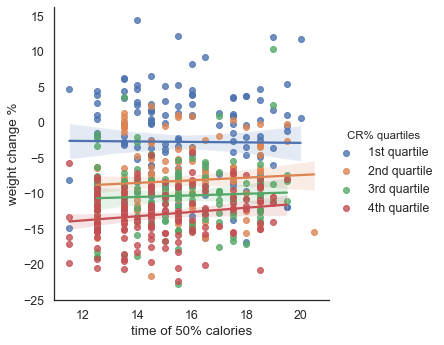

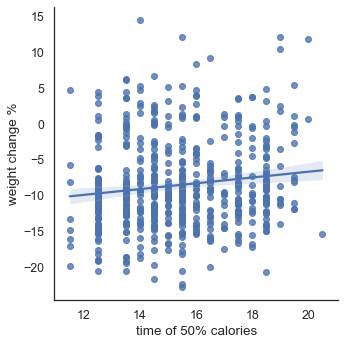

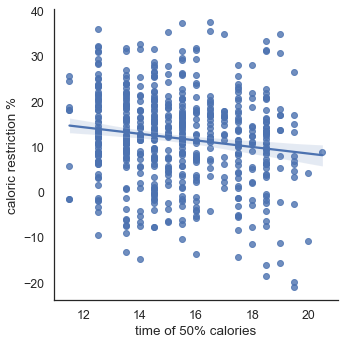

In [90]:
linear_models(ddat, 'time of 50% calories')

# Secondary linear analysis

### Relationship between eating pattern variables

We have no evidence of a systematic difference between treatment groups or time points for any eating pattern variable. Therefore we will do plain old linear regressions between them


Out of 587 datapoints, dropping 0
mean_daily_eating_interval ~ eating_interval_mid_95pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     mean_daily_eating_interval   R-squared:                       0.623
Model:                                    OLS   Adj. R-squared:                  0.622
Method:                         Least Squares   F-statistic:                     955.1
Date:                        Wed, 04 Aug 2021   Prob (F-statistic):          1.31e-124
Time:                                15:42:31   Log-Likelihood:                -821.29
No. Observations:                         581   AIC:                             1647.
Df Residuals:                             579   BIC:                             1655.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.7305      0.326      5.309      0.000       1.090       2.371
eating_interval_mid_95pct     0.7269      0.024     30.904      0.000       0.681       0.773
==============================================================================
Omnibus:                      158.445   Durbin-Watson:                   1.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              541.729
Skew:                          -1.252   Prob(JB):                    2.32e-118
Kurtosis:                       7.014   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_daily_eating_interval,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,1.7305,0.326,5.309,0.0,1.090,2.371,NaN
eating_interval_mid_95pct,0.7269,0.024,30.904,0.0,0.681,0.773,0.62257
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.37743


Out of 587 datapoints, dropping 0
time_of_50pct_calories ~ eating_interval_mid_95pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_of_50pct_calories   R-squared:                       0.024
Model:                                OLS   Adj. R-squared:                  0.022
Method:                     Least Squares   F-statistic:                     14.32
Date:                    Wed, 04 Aug 2021   Prob (F-statistic):           0.000170
Time:                            15:42:32   Log-Likelihood:                -1234.4
No. Observations:                     581   AIC:                             2473.
Df Residuals:                         579   BIC:                             2482.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    12.8762      0.664     19.399      0.000      11.573      14.180
eating_interval_mid_95pct     0.1812      0.048      3.784      0.000       0.087       0.275
==============================================================================
Omnibus:                       54.000   Durbin-Watson:                   1.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.332
Skew:                           0.259   Prob(JB):                     1.41e-05
Kurtosis:                       2.191   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: time_of_50pct_calories,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,12.8762,0.664,19.399,0.0,11.573,14.180,NaN
eating_interval_mid_95pct,0.1812,0.048,3.784,0.0,0.087,0.275,0.024132
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.975868


Out of 587 datapoints, dropping 0
mean_firstmeal_shift ~ eating_interval_mid_95pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     mean_firstmeal_shift   R-squared:                       0.079
Model:                              OLS   Adj. R-squared:                  0.077
Method:                   Least Squares   F-statistic:                     49.58
Date:                  Wed, 04 Aug 2021   Prob (F-statistic):           5.41e-12
Time:                          15:42:34   Log-Likelihood:                -634.98
No. Observations:                   581   AIC:                             1274.
Df Residuals:                       579   BIC:                             1283.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.6124      0.237     -2.589      0.010      -1.077      -0.148
eating_interval_mid_95pct     0.1202      0.017      7.041      0.000       0.087       0.154
==============================================================================
Omnibus:                      268.243   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1787.016
Skew:                           1.932   Prob(JB):                         0.00
Kurtosis:                      10.673   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_firstmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-0.6124,0.237,-2.589,0.01,-1.077,-0.148,NaN
eating_interval_mid_95pct,0.1202,0.017,7.041,0.00,0.087,0.154,0.078879
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.921121


Out of 587 datapoints, dropping 0
mean_lastmeal_shift ~ eating_interval_mid_95pct


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_lastmeal_shift   R-squared:                       0.149
Model:                             OLS   Adj. R-squared:                  0.148
Method:                  Least Squares   F-statistic:                     101.4
Date:                 Wed, 04 Aug 2021   Prob (F-statistic):           4.45e-22
Time:                         15:42:35   Log-Likelihood:                -715.99
No. Observations:                  581   AIC:                             1436.
Df Residuals:                      579   BIC:                             1445.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.1810      0.272     -4.343      0.000      -1.715      -0.647
eating_interval_mid_95pct     0.1975      0.020     10.067      0.000       0.159       0.236
==============================================================================
Omnibus:                      118.149   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.390
Skew:                           1.121   Prob(JB):                     6.31e-53
Kurtosis:                       5.214   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_lastmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-1.1810,0.272,-4.343,0.0,-1.715,-0.647,NaN
eating_interval_mid_95pct,0.1975,0.020,10.067,0.0,0.159,0.236,0.148973
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.851027


Out of 587 datapoints, dropping 0
eating_interval_mid_95pct ~ mean_daily_eating_interval


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     eating_interval_mid_95pct   R-squared:                       0.623
Model:                                   OLS   Adj. R-squared:                  0.622
Method:                        Least Squares   F-statistic:                     955.1
Date:                       Wed, 04 Aug 2021   Prob (F-statistic):          1.31e-124
Time:                               15:42:37   Log-Likelihood:                -868.95
No. Observations:                        581   AIC:                             1742.
Df Residuals:                            579   BIC:                             1751.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.7062      0.328     11.301      0.000       3.062       4.350
mean_daily_eating_interval     0.8565      0.028     30.904      0.000       0.802       0.911
==============================================================================
Omnibus:                      209.236   Durbin-Watson:                   1.557
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.235
Skew:                           1.610   Prob(JB):                    2.63e-187
Kurtosis:                       8.012   Cond. No.                         87.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: eating_interval_mid_95pct,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,3.7062,0.328,11.301,0.0,3.062,4.350,NaN
mean_daily_eating_interval,0.8565,0.028,30.904,0.0,0.802,0.911,0.62257
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.37743


Out of 587 datapoints, dropping 0
time_of_50pct_calories ~ mean_daily_eating_interval


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_of_50pct_calories   R-squared:                       0.001
Model:                                OLS   Adj. R-squared:                 -0.001
Method:                     Least Squares   F-statistic:                    0.6849
Date:                    Wed, 04 Aug 2021   Prob (F-statistic):              0.408
Time:                            15:42:38   Log-Likelihood:                -1241.2
No. Observations:                     581   AIC:                             2486.
Df Residuals:                         579   BIC:                             2495.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     14.8572      0.622     23.870      0.000      13.635      16.080
mean_daily_eating_interval     0.0435      0.053      0.828      0.408      -0.060       0.147
==============================================================================
Omnibus:                       69.014   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.209
Skew:                           0.270   Prob(JB):                     3.36e-06
Kurtosis:                       2.134   Cond. No.                         87.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: time_of_50pct_calories,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,14.8572,0.622,23.870,0.000,13.635,16.080,NaN
mean_daily_eating_interval,0.0435,0.053,0.828,0.408,-0.060,0.147,0.001182
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.998818


Out of 587 datapoints, dropping 0
mean_firstmeal_shift ~ mean_daily_eating_interval


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     mean_firstmeal_shift   R-squared:                       0.025
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     14.85
Date:                  Wed, 04 Aug 2021   Prob (F-statistic):           0.000129
Time:                          15:42:39   Log-Likelihood:                -651.49
No. Observations:                   581   AIC:                             1307.
Df Residuals:                       579   BIC:                             1316.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.9008      0.226      8.427      0.000       1.458       2.344
mean_daily_eating_interval    -0.0735      0.019     -3.854      0.000      -0.111      -0.036
==============================================================================
Omnibus:                      271.308   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1797.961
Skew:                           1.962   Prob(JB):                         0.00
Kurtosis:                      10.673   Cond. No.                         87.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_firstmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,1.9008,0.226,8.427,0.0,1.458,2.344,NaN
mean_daily_eating_interval,-0.0735,0.019,-3.854,0.0,-0.111,-0.036,0.025008
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.974992


Out of 587 datapoints, dropping 0
mean_lastmeal_shift ~ mean_daily_eating_interval


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_lastmeal_shift   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.1105
Date:                 Wed, 04 Aug 2021   Prob (F-statistic):              0.740
Time:                         15:42:41   Log-Likelihood:                -762.80
No. Observations:                  581   AIC:                             1530.
Df Residuals:                      579   BIC:                             1538.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.6245      0.273      5.946      0.000       1.088       2.161
mean_daily_eating_interval    -0.0077      0.023     -0.332      0.740      -0.053       0.038
==============================================================================
Omnibus:                      134.544   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.008
Skew:                           1.220   Prob(JB):                     1.59e-66
Kurtosis:                       5.561   Cond. No.                         87.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_lastmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,1.6245,0.273,5.946,0.00,1.088,2.161,NaN
mean_daily_eating_interval,-0.0077,0.023,-0.332,0.74,-0.053,0.038,0.000191
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.999809


Out of 587 datapoints, dropping 0
eating_interval_mid_95pct ~ time_of_50pct_calories


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     eating_interval_mid_95pct   R-squared:                       0.024
Model:                                   OLS   Adj. R-squared:                  0.022
Method:                        Least Squares   F-statistic:                     14.32
Date:                       Wed, 04 Aug 2021   Prob (F-statistic):           0.000170
Time:                               15:42:42   Log-Likelihood:                -1144.9
No. Observations:                        581   AIC:                             2294.
Df Residuals:                            579   BIC:                             2303.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.7001      0.546     21.445      0.000      10.629      12.772
time_of_50pct_calories     0.1332      0.035      3.784      0.000       0.064       0.202
==============================================================================
Omnibus:                      160.792   Durbin-Watson:                   1.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              778.097
Skew:                           1.148   Prob(JB):                    1.09e-169
Kurtosis:                       8.183   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: eating_interval_mid_95pct,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,11.7001,0.546,21.445,0.0,10.629,12.772,NaN
time_of_50pct_calories,0.1332,0.035,3.784,0.0,0.064,0.202,0.024132
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.975868


Out of 587 datapoints, dropping 0
mean_daily_eating_interval ~ time_of_50pct_calories


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     mean_daily_eating_interval   R-squared:                       0.001
Model:                                    OLS   Adj. R-squared:                 -0.001
Method:                         Least Squares   F-statistic:                    0.6849
Date:                        Wed, 04 Aug 2021   Prob (F-statistic):              0.408
Time:                                15:42:44   Log-Likelihood:                -1104.0
No. Observations:                         581   AIC:                             2212.
Df Residuals:                             579   BIC:                             2221.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.3054      0.508     22.234      0.000      10.307      12.304
time_of_50pct_calories     0.0271      0.033      0.828      0.408      -0.037       0.092
==============================================================================
Omnibus:                       24.962   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.389
Skew:                           0.026   Prob(JB):                     1.41e-15
Kurtosis:                       4.680   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_daily_eating_interval,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,11.3054,0.508,22.234,0.000,10.307,12.304,NaN
time_of_50pct_calories,0.0271,0.033,0.828,0.408,-0.037,0.092,0.001182
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.998818


Out of 587 datapoints, dropping 0
mean_firstmeal_shift ~ time_of_50pct_calories


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     mean_firstmeal_shift   R-squared:                       0.037
Model:                              OLS   Adj. R-squared:                  0.035
Method:                   Least Squares   F-statistic:                     22.09
Date:                  Wed, 04 Aug 2021   Prob (F-statistic):           3.25e-06
Time:                          15:42:45   Log-Likelihood:                -647.97
No. Observations:                   581   AIC:                             1300.
Df Residuals:                       579   BIC:                             1309.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0410      0.232     -0.177      0.860      -0.497       0.415
time_of_50pct_calories     0.0703      0.015      4.700      0.000       0.041       0.100
==============================================================================
Omnibus:                      262.749   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1679.780
Skew:                           1.900   Prob(JB):                         0.00
Kurtosis:                      10.413   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_firstmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,-0.0410,0.232,-0.177,0.86,-0.497,0.415,NaN
time_of_50pct_calories,0.0703,0.015,4.700,0.00,0.041,0.100,0.036757
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.963243


Out of 587 datapoints, dropping 0
mean_lastmeal_shift ~ time_of_50pct_calories


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_lastmeal_shift   R-squared:                       0.020
Model:                             OLS   Adj. R-squared:                  0.018
Method:                  Least Squares   F-statistic:                     11.76
Date:                 Wed, 04 Aug 2021   Prob (F-statistic):           0.000649
Time:                         15:42:46   Log-Likelihood:                -757.01
No. Observations:                  581   AIC:                             1518.
Df Residuals:                      579   BIC:                             1527.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.5834      0.280      2.085      0.038       0.034       1.133
time_of_50pct_calories     0.0619      0.018      3.429      0.001       0.026       0.097
==============================================================================
Omnibus:                      136.326   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              310.553
Skew:                           1.231   Prob(JB):                     3.67e-68
Kurtosis:                       5.601   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_lastmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,0.5834,0.280,2.085,0.038,0.034,1.133,NaN
time_of_50pct_calories,0.0619,0.018,3.429,0.001,0.026,0.097,0.019903
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.980097


Out of 587 datapoints, dropping 0
eating_interval_mid_95pct ~ mean_firstmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     eating_interval_mid_95pct   R-squared:                       0.079
Model:                                   OLS   Adj. R-squared:                  0.077
Method:                        Least Squares   F-statistic:                     49.58
Date:                       Wed, 04 Aug 2021   Prob (F-statistic):           5.41e-12
Time:                               15:42:48   Log-Likelihood:                -1128.1
No. Observations:                        581   AIC:                             2260.
Df Residuals:                            579   BIC:                             2269.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               13.0640      0.120    109.227      0.000      12.829      13.299
mean_firstmeal_shift     0.6563      0.093      7.041      0.000       0.473       0.839
==============================================================================
Omnibus:                      101.120   Durbin-Watson:                   1.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              328.234
Skew:                           0.804   Prob(JB):                     5.31e-72
Kurtosis:                       6.312   Cond. No.                         3.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: eating_interval_mid_95pct,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,13.0640,0.120,109.227,0.0,12.829,13.299,NaN
mean_firstmeal_shift,0.6563,0.093,7.041,0.0,0.473,0.839,0.078879
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.921121


Out of 587 datapoints, dropping 0
mean_daily_eating_interval ~ mean_firstmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     mean_daily_eating_interval   R-squared:                       0.025
Model:                                    OLS   Adj. R-squared:                  0.023
Method:                         Least Squares   F-statistic:                     14.85
Date:                        Wed, 04 Aug 2021   Prob (F-statistic):           0.000129
Time:                                15:42:49   Log-Likelihood:                -1097.0
No. Observations:                         581   AIC:                             2198.
Df Residuals:                             579   BIC:                             2207.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.0765      0.113    106.532      0.000      11.854      12.299
mean_firstmeal_shift    -0.3404      0.088     -3.854      0.000      -0.514      -0.167
==============================================================================
Omnibus:                       39.921   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.222
Skew:                           0.312   Prob(JB):                     3.16e-24
Kurtosis:                       5.020   Cond. No.                         3.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_daily_eating_interval,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,12.0765,0.113,106.532,0.0,11.854,12.299,NaN
mean_firstmeal_shift,-0.3404,0.088,-3.854,0.0,-0.514,-0.167,0.025008
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.974992


Out of 587 datapoints, dropping 0
time_of_50pct_calories ~ mean_firstmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_of_50pct_calories   R-squared:                       0.037
Model:                                OLS   Adj. R-squared:                  0.035
Method:                     Least Squares   F-statistic:                     22.09
Date:                    Wed, 04 Aug 2021   Prob (F-statistic):           3.25e-06
Time:                            15:42:51   Log-Likelihood:                -1230.7
No. Observations:                     581   AIC:                             2465.
Df Residuals:                         579   BIC:                             2474.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               14.8240      0.143    103.891      0.000      14.544      15.104
mean_firstmeal_shift     0.5227      0.111      4.700      0.000       0.304       0.741
==============================================================================
Omnibus:                       64.538   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.262
Skew:                           0.286   Prob(JB):                     3.27e-06
Kurtosis:                       2.153   Cond. No.                         3.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: time_of_50pct_calories,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,14.8240,0.143,103.891,0.0,14.544,15.104,NaN
mean_firstmeal_shift,0.5227,0.111,4.700,0.0,0.304,0.741,0.036757
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.963243


Out of 587 datapoints, dropping 0
mean_lastmeal_shift ~ mean_firstmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_lastmeal_shift   R-squared:                       0.085
Model:                             OLS   Adj. R-squared:                  0.084
Method:                  Least Squares   F-statistic:                     54.08
Date:                 Wed, 04 Aug 2021   Prob (F-statistic):           6.61e-13
Time:                         15:42:52   Log-Likelihood:                -736.91
No. Observations:                  581   AIC:                             1478.
Df Residuals:                      579   BIC:                             1487.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.1711      0.061     19.199      0.000       1.051       1.291
mean_firstmeal_shift     0.3496      0.048      7.354      0.000       0.256       0.443
==============================================================================
Omnibus:                      103.400   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.703
Skew:                           1.053   Prob(JB):                     1.29e-40
Kurtosis:                       4.775   Cond. No.                         3.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_lastmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,1.1711,0.061,19.199,0.0,1.051,1.291,NaN
mean_firstmeal_shift,0.3496,0.048,7.354,0.0,0.256,0.443,0.085425
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.914575


Out of 587 datapoints, dropping 0
eating_interval_mid_95pct ~ mean_lastmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     eating_interval_mid_95pct   R-squared:                       0.149
Model:                                   OLS   Adj. R-squared:                  0.148
Method:                        Least Squares   F-statistic:                     101.4
Date:                       Wed, 04 Aug 2021   Prob (F-statistic):           4.45e-22
Time:                               15:42:53   Log-Likelihood:                -1105.1
No. Observations:                        581   AIC:                             2214.
Df Residuals:                            579   BIC:                             2223.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.5891      0.133     94.486      0.000      12.327      12.851
mean_lastmeal_shift     0.7541      0.075     10.067      0.000       0.607       0.901
==============================================================================
Omnibus:                      124.932   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              487.031
Skew:                           0.936   Prob(JB):                    1.75e-106
Kurtosis:                       7.076   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: eating_interval_mid_95pct,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,12.5891,0.133,94.486,0.0,12.327,12.851,NaN
mean_lastmeal_shift,0.7541,0.075,10.067,0.0,0.607,0.901,0.148973
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.851027


Out of 587 datapoints, dropping 0
mean_daily_eating_interval ~ mean_lastmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     mean_daily_eating_interval   R-squared:                       0.000
Model:                                    OLS   Adj. R-squared:                 -0.002
Method:                         Least Squares   F-statistic:                    0.1105
Date:                        Wed, 04 Aug 2021   Prob (F-statistic):              0.740
Time:                                15:42:55   Log-Likelihood:                -1104.3
No. Observations:                         581   AIC:                             2213.
Df Residuals:                             579   BIC:                             2221.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              11.7607      0.133     88.398      0.000      11.499      12.022
mean_lastmeal_shift    -0.0249      0.075     -0.332      0.740      -0.172       0.122
==============================================================================
Omnibus:                       24.802   Durbin-Watson:                   1.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.929
Skew:                           0.051   Prob(JB):                     2.93e-15
Kurtosis:                       4.660   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_daily_eating_interval,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,11.7607,0.133,88.398,0.00,11.499,12.022,NaN
mean_lastmeal_shift,-0.0249,0.075,-0.332,0.74,-0.172,0.122,0.000191
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.999809


Out of 587 datapoints, dropping 0
time_of_50pct_calories ~ mean_lastmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     time_of_50pct_calories   R-squared:                       0.020
Model:                                OLS   Adj. R-squared:                  0.018
Method:                     Least Squares   F-statistic:                     11.76
Date:                    Wed, 04 Aug 2021   Prob (F-statistic):           0.000649
Time:                            15:42:56   Log-Likelihood:                -1235.7
No. Observations:                     581   AIC:                             2475.
Df Residuals:                         579   BIC:                             2484.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.8740      0.167     89.167      0.000      14.546      15.202
mean_lastmeal_shift     0.3216      0.094      3.429      0.001       0.137       0.506
==============================================================================
Omnibus:                       63.564   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.664
Skew:                           0.276   Prob(JB):                     4.41e-06
Kurtosis:                       2.155   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: time_of_50pct_calories,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,14.8740,0.167,89.167,0.000,14.546,15.202,NaN
mean_lastmeal_shift,0.3216,0.094,3.429,0.001,0.137,0.506,0.019903
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.980097


Out of 587 datapoints, dropping 0
mean_firstmeal_shift ~ mean_lastmeal_shift


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     mean_firstmeal_shift   R-squared:                       0.085
Model:                              OLS   Adj. R-squared:                  0.084
Method:                   Least Squares   F-statistic:                     54.08
Date:                  Wed, 04 Aug 2021   Prob (F-statistic):           6.61e-13
Time:                          15:42:58   Log-Likelihood:                -632.90
No. Observations:                   581   AIC:                             1270.
Df Residuals:                       579   BIC:                             1279.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6647      0.059     11.246      0.000       0.549       0.781
mean_lastmeal_shift     0.2444      0.033      7.354      0.000       0.179       0.310
==============================================================================
Omnibus:                      220.647   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1079.254
Skew:                           1.638   Prob(JB):                    4.40e-235
Kurtosis:                       8.818   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent var: mean_firstmeal_shift,coef,std err,t,P>|t|,[0.025,0.975],Var explained
Intercept,0.6647,0.059,11.246,0.0,0.549,0.781,NaN
mean_lastmeal_shift,0.2444,0.033,7.354,0.0,0.179,0.310,0.085425
Residual,NaN,NaN,NaN,NaN,NaN,NaN,0.914575


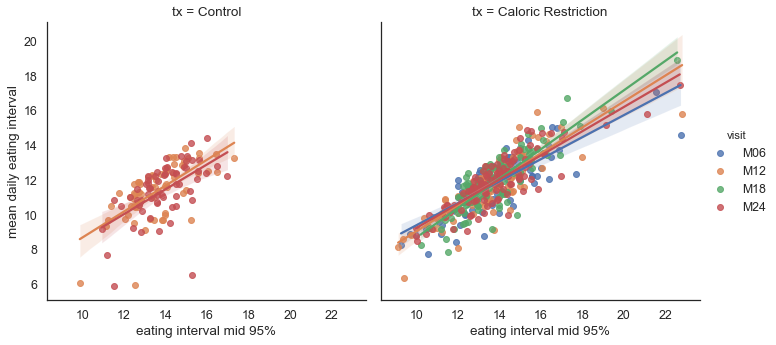

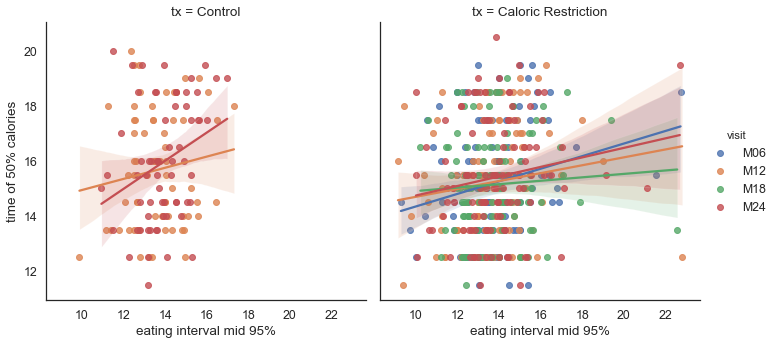

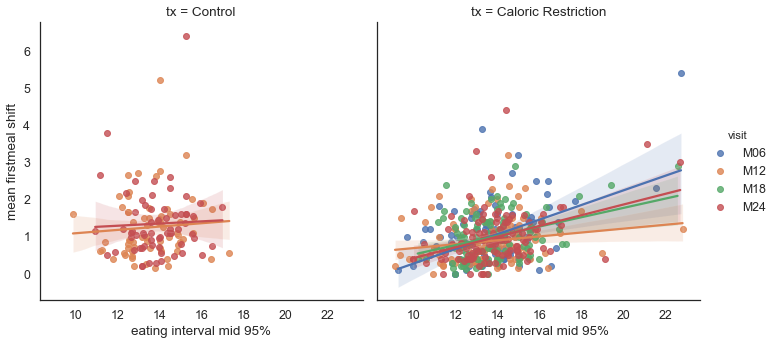

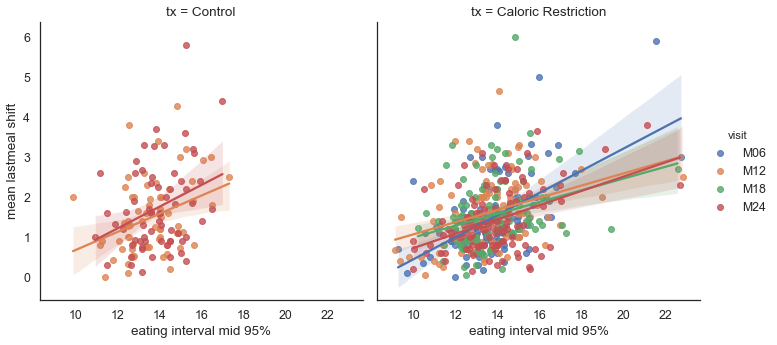

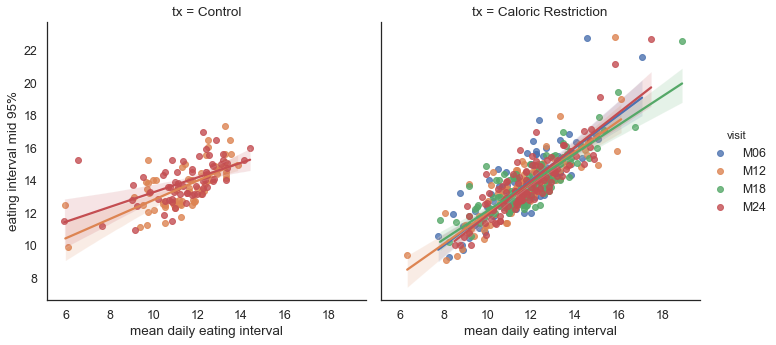

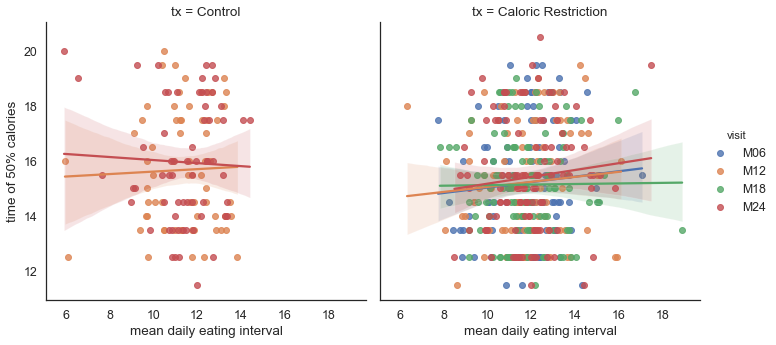

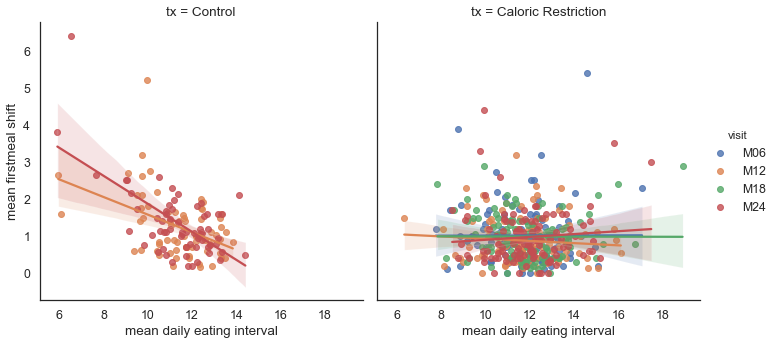

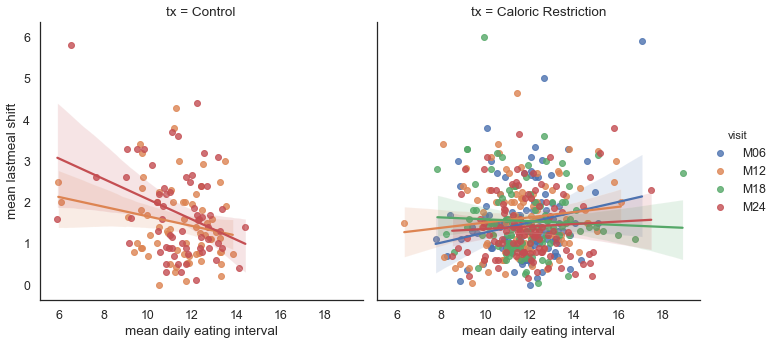

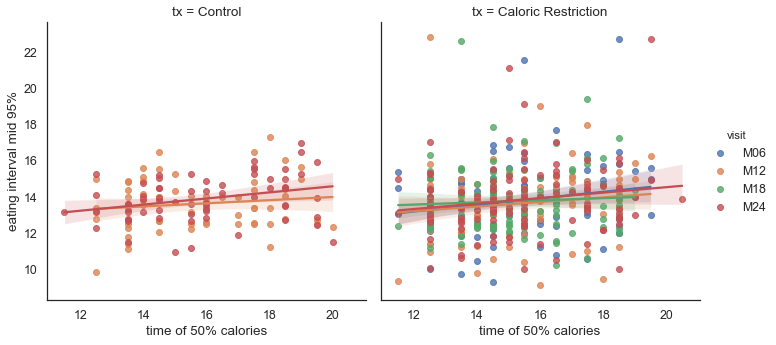

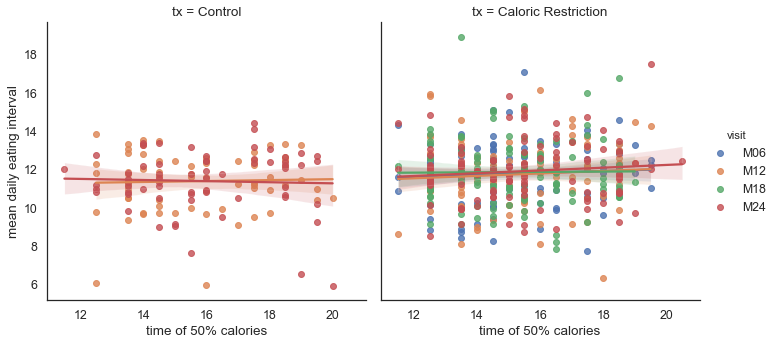

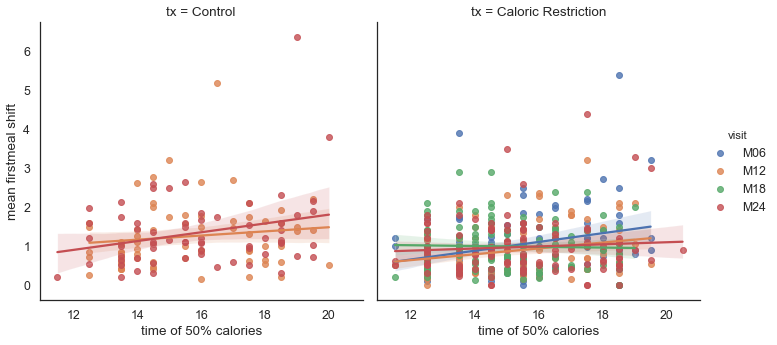

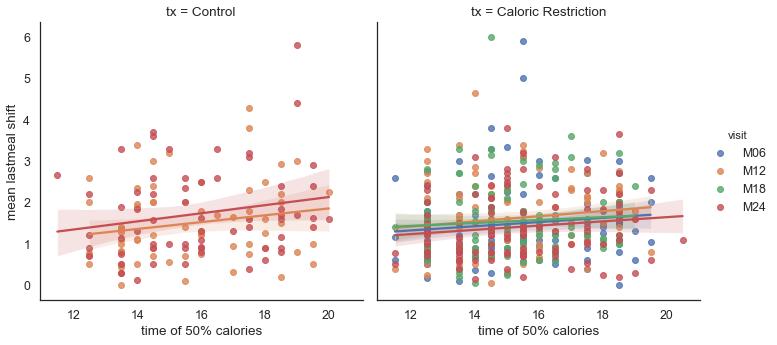

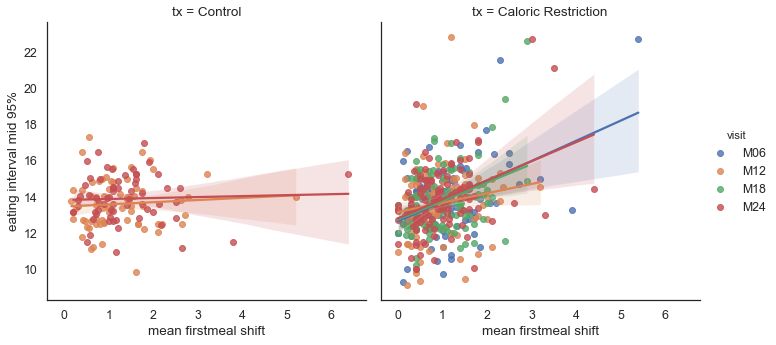

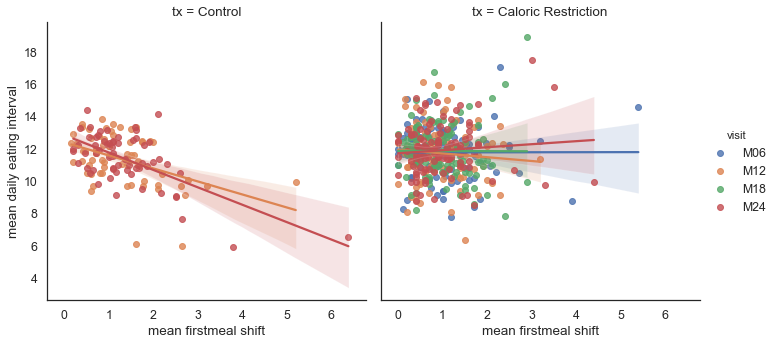

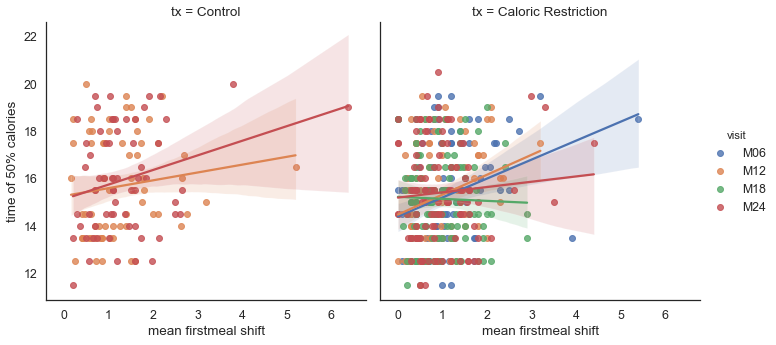

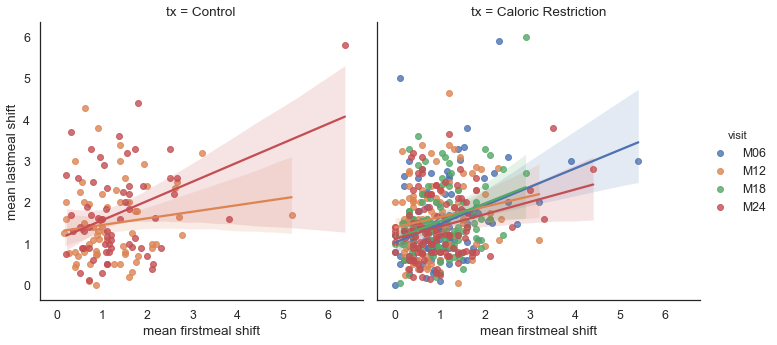

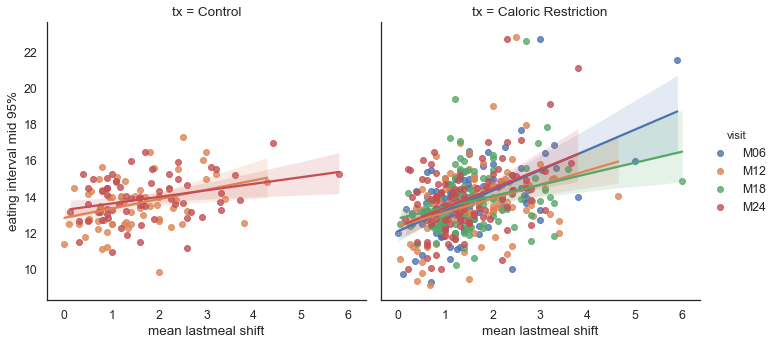

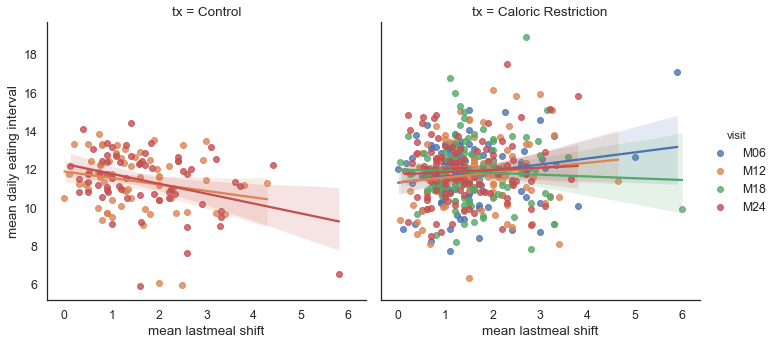

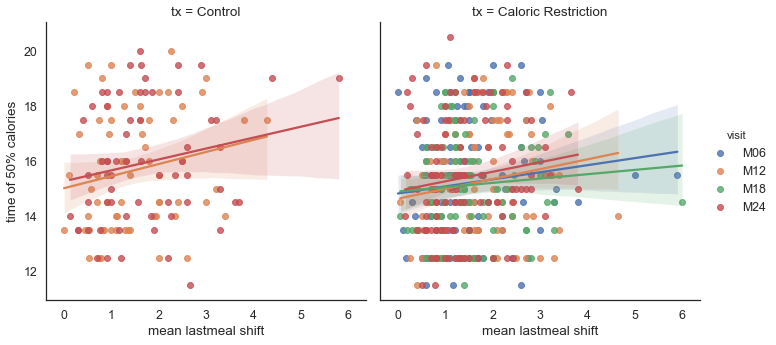

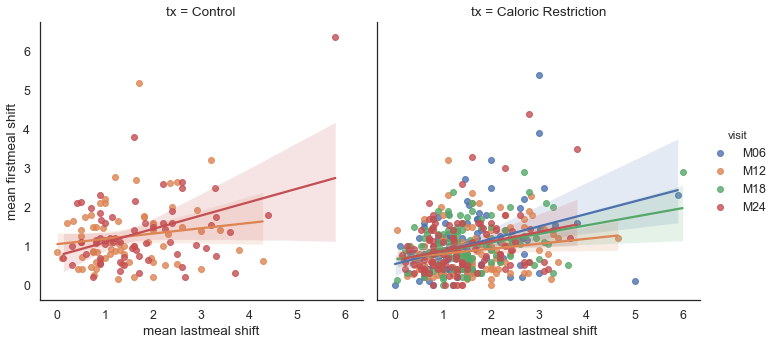

In [91]:
tocheck = [
    'eating interval mid 95%',
    'mean daily eating interval',
    'time of 50% calories',
    'mean firstmeal shift',
    'mean lastmeal shift'
]

for v in tocheck:
    for o in tocheck:
        if v==o:
            continue 
            
        # check robustness by getting rid of people who are >97.5%ile or <2.5%ile
        dc = ddat[v].quantile(0.025)
        todrop1 = ddat.index[ ddat[v]<dc ].to_series()
        dc = ddat[v].quantile(0.975)
        todrop2 = ddat.index[ ddat[v]>dc ].to_series()
        todrop = pd.concat([todrop1, todrop2])
        # or don't if this is uncommented below (eliminates todrop)
        todrop=[]

        print('Out of {} datapoints, dropping {}'.format( len(ddat), len(todrop)) )
        ll = ddat.drop(todrop).reset_index()

        # remove problem characters from variable names to make LMER style formulas work
        ny = o.replace(' ','_').replace('%','pct')
        nx = v.replace(' ','_').replace('%','pct')
        ndat = ll.rename({o:ny, v:nx, 'caloric restriction %':'caloric_restriction_pct'},axis=1)
        formula = '{} ~ {}'.format(ny,nx)
        print(formula)

        model = ols(formula,ndat).fit()

        h = sns.lmplot(data=ll, x=v, y=o, col='tx',
                      hue='visit', hue_order=['M06','M12','M18','M24'])

        sns.despine()
        plt.savefig(outdir+nx+'_tx_visit_'+ny+'.png',dpi=300)

        with open(outdir+'tab1_'+nx+'_tx_visit_'+ny+'.csv','w') as csvf:
            csvf.write(model.summary().as_csv())
            csvf.close()

        res = anova_lm(model)
        var_explained = (res['sum_sq']/res['sum_sq'].sum()).rename('Var explained')
        results_summary = model.summary()
        results_as_html = results_summary.tables[1].as_html()
        output = pd.read_html(results_as_html, header=0, index_col=0)[0].join(var_explained, how='outer')
        output.columns.name='Dependent var: '+model.model.endog_names
        output = shift_row_to_bottom(output,1)
        output.to_csv(outdir+'tab2_'+nx+'_tx_visit_'+ny+'.csv')

        display(model.summary())
        display(output)

# Other analyses




### Is there any difference between CR vs Controls in terms of our variables of interest?

No. There is no good evidence (p>0.12 in all cases, mostly much bigger)

Difference in 95%tile eating interval between CR and Control at Baseline? Ttest_indResult(statistic=-0.31826246296615995, pvalue=0.7506429157993757)


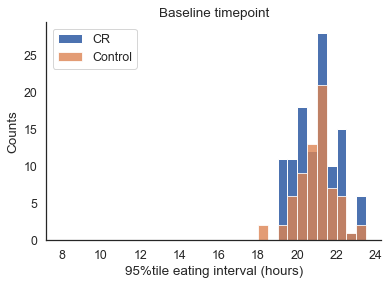

In [92]:
a = ptile_year.query('year == "Baseline" and tx=="Control"')['95%']
b = ptile_year.query('year == "Baseline" and tx=="Caloric Restriction"')['95%']
print ("Difference in 95%tile eating interval between CR and Control at Baseline?", stats.ttest_ind(a,b ))
sns.set_style('white')

b.hist(bins=np.arange(8.,24.,0.5), label='CR')
a.hist(bins=np.arange(8.,24.,0.5), label='Control', alpha=0.8)

plt.ylabel('Counts')
plt.xlabel('95%tile eating interval (hours)')
plt.title('Baseline timepoint')
plt.legend()
plt.grid(False)
sns.despine()

Difference in mean firstmeal shift between CR and Control at Baseline? Ttest_indResult(statistic=1.5299103843445054, pvalue=0.1277378325090277)


,count,mean,std,min,25%,50%,75%,max
tx,,,,,,,,
Caloric Restriction,117.0,1.103030,0.631044,0.272727,0.636364,0.954545,1.454545,3.272727
Control,71.0,1.250538,0.656910,0.272727,0.727273,1.257576,1.579545,3.045455


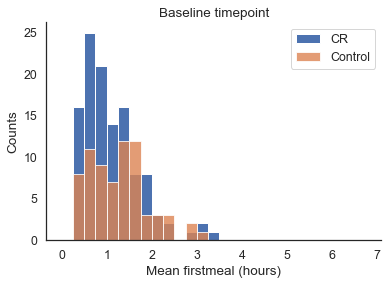

In [93]:
a = mean_firstmeal_shift.query('visit == "BL" and tx=="Control"')['mean firstmeal shift']
b = mean_firstmeal_shift.query('visit == "BL" and tx=="Caloric Restriction"')['mean firstmeal shift']
print ("Difference in mean firstmeal shift between CR and Control at Baseline?", stats.ttest_ind(a,b ))
sns.set_style('white')

b.hist(bins=np.arange(0,7,0.25), label='CR')
a.hist(bins=np.arange(0,7,0.25), label='Control', alpha=0.8)

plt.ylabel('Counts')
plt.xlabel('Mean firstmeal (hours)')
plt.title('Baseline timepoint')
plt.legend()
plt.grid(False)
sns.despine()

mean_firstmeal_shift.query('visit == "BL"').groupby('tx')['mean firstmeal shift'].describe()

Difference in mean lastmeal shift between CR and Control at Baseline? Ttest_indResult(statistic=0.14668378021250308, pvalue=0.8835404850758076)


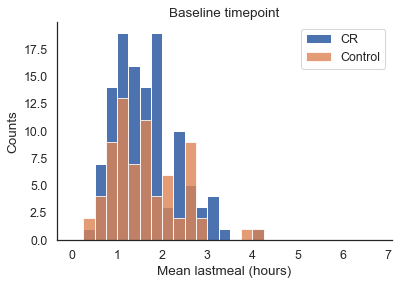

In [94]:
a = mean_lastmeal_shift.query('visit == "BL" and tx=="Control"')['mean lastmeal shift']
b = mean_lastmeal_shift.query('visit == "BL" and tx=="Caloric Restriction"')['mean lastmeal shift']
print ("Difference in mean lastmeal shift between CR and Control at Baseline?", stats.ttest_ind(a,b ))
sns.set_style('white')


b.hist(bins=np.arange(0,7,0.25), label='CR')
a.hist(bins=np.arange(0,7,0.25), label='Control', alpha=0.8)


plt.ylabel('Counts')
plt.xlabel('Mean lastmeal (hours)')
plt.title('Baseline timepoint')
plt.legend()
plt.grid(False)
sns.despine()

Difference in time of 50%tile calories between CR and Control at Baseline? Ttest_indResult(statistic=-0.08165533160105697, pvalue=0.9350085999357777)


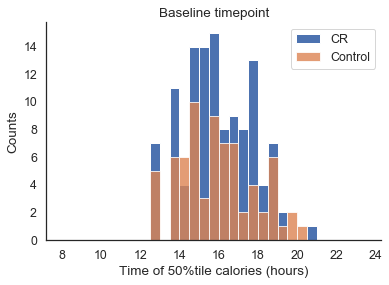

In [95]:
time_of_50pct_cal = kcal_by_subj.apply( axis=1, func=lambda x: x.where( x > 0.5).dropna().index[0] ).to_frame()
a = time_of_50pct_cal.query('visit == "BL" and tx=="Control"')[0]
b = time_of_50pct_cal.query('visit == "BL" and tx=="Caloric Restriction"')[0]
print ("Difference in time of 50%tile calories between CR and Control at Baseline?", stats.ttest_ind(a,b ))
sns.set_style('white')

b.hist(bins=np.arange(8.,24.,0.5), label='CR')
a.hist(bins=np.arange(8.,24.,0.5), label='Control', alpha=0.8)

plt.ylabel('Counts')
plt.xlabel('Time of 50%tile calories (hours)')
plt.title('Baseline timepoint')
plt.legend()
plt.grid(False)
sns.despine()


### Is there a change in CR treatment group over time in terms of 95%tile eating intervals?

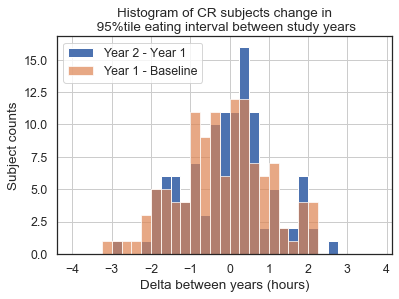

In [96]:
ptile_year.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"').apply(lambda x: x['Year 2'] - x['Year 1'] ,  axis=1).hist(bins=np.arange(-4.,4.,0.25), label='Year 2 - Year 1')
ptile_year.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"').apply(lambda x: x['Year 1'] - x['Baseline'] ,  axis=1).hist(bins=np.arange(-4.,4.,0.25), label='Year 1 - Baseline', alpha = 0.7)

plt.ylabel('Subject counts')
plt.xlabel('Delta between years (hours)')
plt.title('Histogram of CR subjects change in\n 95%tile eating interval between study years')
plt.legend();

In [97]:
ptile_visit_mean = meals.groupby(['deidnum','visname','tx'])['Hour of day'].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])#.unstack() -- seems there are some version differences
ll = ['2.5%','5%','10%','12.5%','25%']
ul = ['97.5%','95%', '90%','87.5%', '75%']
mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
for low, upp, midp in zip(ll,ul,mp):
    ptile_visit_mean[midp] = ptile_visit_mean[upp] - ptile_visit_mean[low]
ptile_visit_mean.set_index( ptile_visit_mean.reset_index()['visname'].apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if (x in ['M6','M12']) else 'Year 2').rename('year'), append=True, inplace=True)
ptile_visit_mean = ptile_visit_mean[mp].groupby(['deidnum','year','tx'] ).mean()
ptile_visit_mean[mp]

duration mid 95%  duration mid 90%  \
deidnum year     tx                                                        
1057    Baseline Caloric Restriction         13.820833         13.585417   
        Year 1   Caloric Restriction         14.016667         13.062500   
        Year 2   Caloric Restriction         13.475000         13.250000   
1948    Baseline Control                     15.625000         14.925000   
        Year 1   Control                     14.000000         14.000000   
...                                                ...               ...   
99413   Year 1   Caloric Restriction         12.987500         12.225000   
        Year 2   Caloric Restriction         13.687500         13.118750   
99866   Baseline Control                     13.000000         13.000000   
        Year 1   Control                     12.525000         12.050000   
        Year 2   Control                     12.883333         12.600000   

                                      duration mid 80%  duration mid 75%  \
deidnum year     tx                                                        
1057    Baseline Caloric Restriction         11.925000         11.031250   
        Year 1   Caloric Restriction         11.300000         10.968750   
        Year 2   Caloric Restriction         12.450000         11.875000   
1948    Baseline Control                     13.000000         12.187500   
        Year 1   Control                     12.500000         10.875000   
...                                                ...               ...   
99413   Year 1   Caloric Restriction         11.650000         11.062500   
        Year 2   Caloric Restriction         11.783333         11.296875   
99866   Baseline Control                     12.116667         11.875000   
        Year 1   Control                     11.100000         10.812500   
        Year 2   Control                     11.800000         11.437500   

                                      duration mid 50%  
deidnum year     tx                                     
1057    Baseline Caloric Restriction          8.812500  
        Year 1   Caloric Restriction          9.062500  
        Year 2   Caloric Restriction          9.000000  
1948    Baseline Control                      8.375000  
        Year 1   Control                      7.312500  
...                                                ...  
99413   Year 1   Caloric Restriction          7.625000  
        Year 2   Caloric Restriction          7.895833  
99866   Baseline Control                      9.000000  
        Year 1   Control                      7.500000  
        Year 2   Control                      9.125000  

[556 rows x 5 columns]

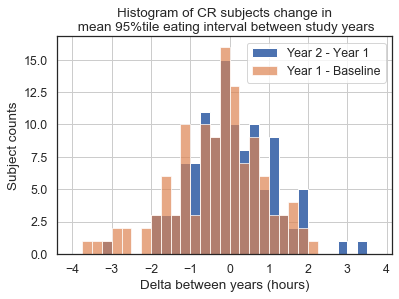

In [98]:
ptile_visit_mean.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"').apply(lambda x: x['Year 2'] - x['Year 1'] ,  axis=1).hist(bins=np.arange(-4.,4.,0.25), label='Year 2 - Year 1')
ptile_visit_mean.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"').apply(lambda x: x['Year 1'] - x['Baseline'] ,  axis=1).hist(bins=np.arange(-4.,4.,0.25), label='Year 1 - Baseline', alpha = 0.7)

plt.ylabel('Subject counts')
plt.xlabel('Delta between years (hours)')
plt.title('Histogram of CR subjects change in\n mean 95%tile eating interval between study years')
plt.legend();

In [99]:

a=ptile_visit_mean.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"').apply(lambda x: x['Year 2'] - x['Year 1'] ,  axis=1).dropna()
b=ptile_visit_mean.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"').apply(lambda x: x['Year 1'] - x['Baseline'] ,  axis=1).dropna()
c=ptile_visit_mean.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"').apply(lambda x: x['Year 2'] - x['Baseline'] ,  axis=1).dropna()
print (stats.f_oneway(a,b,c))
print ("Baseline vs Year 1", stats.ttest_ind(a,b ))
print ("Year 1 vs Year 2", stats.ttest_ind(c,b ))
print ("Baseline vs Year 2", stats.ttest_ind(a,c ))

F_onewayResult(statistic=2.8024848457985176, pvalue=0.062036779490848466)
Baseline vs Year 1 Ttest_indResult(statistic=2.2946113269890938, pvalue=0.02265330566639643)
Year 1 vs Year 2 Ttest_indResult(statistic=0.4452315194152049, pvalue=0.6565693880664449)
Baseline vs Year 2 Ttest_indResult(statistic=1.7091531585303485, pvalue=0.08877143811867655)


F_onewayResult(statistic=1.6112757888214027, pvalue=0.20037866188171785)
Baseline vs Year 1 Ttest_indResult(statistic=1.7542264189708412, pvalue=0.08005182904717963)
Year 1 vs Year 2 Ttest_indResult(statistic=0.5429573911640372, pvalue=0.5874215499652204)
Baseline vs Year 2 Ttest_indResult(statistic=1.2193988620948917, pvalue=0.22331367231659507)


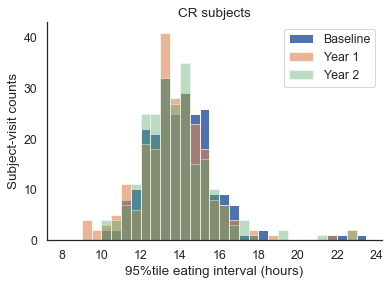

In [100]:


ptile_visit = meals.groupby(['deidnum','visname','tx'])['Hour of day'].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])#.unstack() -- seems there are some version differences
ll = ['2.5%','5%','10%','12.5%','25%']
ul = ['97.5%','95%', '90%','87.5%', '75%']
mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
for low, upp, midp in zip(ll,ul,mp):
    ptile_visit[midp] = ptile_visit[upp] - ptile_visit[low]
ptile_visit.set_index( ptile_visit.reset_index()['visname'].apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if (x in ['M6','M12']) else 'Year 2').rename('year'), append=True, inplace=True)
#ptile_visit = ptile_visit[mp].groupby(['deidnum','year','tx'] ).mean()
#ptile_visit[mp]

a = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"')['Baseline'].dropna()
b = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"')['Year 1'].dropna()
c = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"')['Year 2'].dropna()

sns.set_style('white')
a.hist(bins=np.arange(8.,24.,0.5), label='Baseline')
b.hist(bins=np.arange(8.,24.,0.5), label='Year 1', alpha = 0.6)
c.hist(bins=np.arange(8.,24.,0.5), label='Year 2', alpha = 0.4)

plt.ylabel('Subject-visit counts')
plt.xlabel('95%tile eating interval (hours)')
plt.title('CR subjects')
plt.legend()
plt.grid(False)
sns.despine()
print (stats.f_oneway(a,b,c))
print ("Baseline vs Year 1", stats.ttest_ind(a,b ))
print ("Year 1 vs Year 2", stats.ttest_ind(c,b ))
print ("Baseline vs Year 2", stats.ttest_ind(a,c ))
plt.savefig(outdir+'hist_95pct_eating_interval_cr.png',dpi=300)

F_onewayResult(statistic=0.7700904289376566, pvalue=0.4639742333736635)
Baseline vs Year 1 Ttest_indResult(statistic=1.0565442231578126, pvalue=0.2919511360077258)
Year 1 vs Year 2 Ttest_indResult(statistic=1.2156157271372618, pvalue=0.22628468845012342)
Baseline vs Year 2 Ttest_indResult(statistic=-0.1884004948635488, pvalue=0.850748177359707)


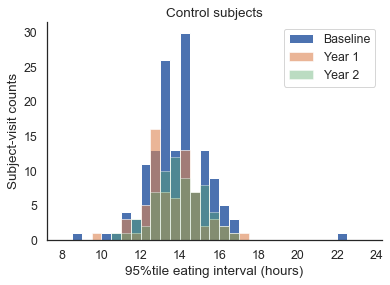

In [101]:


ptile_visit = meals.groupby(['deidnum','visname','tx'])['Hour of day'].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])#.unstack() -- seems there are some version differences
ll = ['2.5%','5%','10%','12.5%','25%']
ul = ['97.5%','95%', '90%','87.5%', '75%']
mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
for low, upp, midp in zip(ll,ul,mp):
    ptile_visit[midp] = ptile_visit[upp] - ptile_visit[low]
ptile_visit.set_index( ptile_visit.reset_index()['visname'].apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if (x in ['M6','M12']) else 'Year 2').rename('year'), append=True, inplace=True)
#ptile_visit = ptile_visit[mp].groupby(['deidnum','year','tx'] ).mean()
#ptile_visit[mp]

a = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Control"')['Baseline'].dropna()
b = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Control"')['Year 1'].dropna()
c = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Control"')['Year 2'].dropna()

sns.set_style('white')
a.hist(bins=np.arange(8.,24.,0.5), label='Baseline')
b.hist(bins=np.arange(8.,24.,0.5), label='Year 1', alpha = 0.6)
c.hist(bins=np.arange(8.,24.,0.5), label='Year 2', alpha = 0.4)

plt.ylabel('Subject-visit counts')
plt.xlabel('95%tile eating interval (hours)')
plt.title('Control subjects')
plt.legend()
plt.grid(False)
sns.despine()
print (stats.f_oneway(a,b,c))
print ("Baseline vs Year 1", stats.ttest_ind(a,b ))
print ("Year 1 vs Year 2", stats.ttest_ind(c,b ))
print ("Baseline vs Year 2", stats.ttest_ind(a,c ))
plt.savefig(outdir+'hist_95pct_eating_interval_controls.png',dpi=300)

Control vs CR Ttest_indResult(statistic=-0.6512370477511001, pvalue=0.5152944833654316)


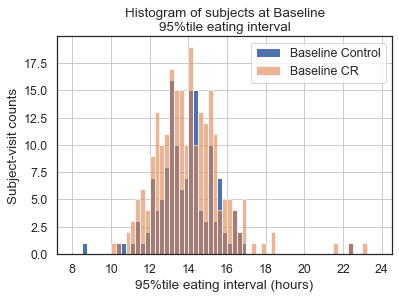

In [102]:


ptile_visit = meals.groupby(['deidnum','visname','tx'])['Hour of day'].describe(percentiles=[.025, .05, .10, .125, .25, .5, .75, .875, .9, .95, .975])#.unstack() -- seems there are some version differences
ll = ['2.5%','5%','10%','12.5%','25%']
ul = ['97.5%','95%', '90%','87.5%', '75%']
mp = ['duration mid 95%', 'duration mid 90%', 'duration mid 80%', 'duration mid 75%','duration mid 50%']
for low, upp, midp in zip(ll,ul,mp):
    ptile_visit[midp] = ptile_visit[upp] - ptile_visit[low]
ptile_visit.set_index( ptile_visit.reset_index()['visname'].apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if (x in ['M6','M12']) else 'Year 2').rename('year'), append=True, inplace=True)
#ptile_visit = ptile_visit[mp].groupby(['deidnum','year','tx'] ).mean()
#ptile_visit[mp]

a = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Control"')['Baseline'].dropna()
b = ptile_visit.loc[:,'duration mid 95%'].unstack('year').query('tx == "Caloric Restriction"')['Baseline'].dropna()
 
a.hist(bins=np.arange(8.,24.,0.25), label='Baseline Control')
b.hist(bins=np.arange(8.,24.,0.25), label='Baseline CR', alpha = 0.6)
#c.hist(bins=np.arange(8.,24.,0.25), label='Year 2', alpha = 0.4)

plt.ylabel('Subject-visit counts')
plt.xlabel('95%tile eating interval (hours)')
plt.title('Histogram of subjects at Baseline\n95%tile eating interval')
plt.legend()
#print (stats.f_oneway(a,b,c))
print ("Control vs CR", stats.ttest_ind(a,b ))
#print ("Year 1 vs Year 2", stats.ttest_ind(c,b ))
#print ("Baseline vs Year 2", stats.ttest_ind(a,c ))

## An aside...

### Question:  
if we calculate daily mean kcal from the food logs, do they match the values in the FOODWEEK table as they should?

### Answer: 
close, but not exact.  Most of the values are < 10kcal off, but they definitely have a systematic bias and there are 6 entries where the difference is > 50kcal and 2 > 100

also, it appears that the FOODWEEK "Baseline" entry is the mean of "BL1" and "BL2" visits

In [103]:
dailycals = meals.groupby(['deidnum','visname','year','tx'])[['KCAL','intakedt']].agg( {'KCAL': lambda x: x.sum(), 'intakedt': lambda x: len(x.unique())} )
dailycals['mean daily kcal']= dailycals['KCAL'] / dailycals['intakedt']
dailycals

KCAL  intakedt  \
deidnum visname year     tx                                         
1057    BL1     Baseline Caloric Restriction   7473.817         6   
        BL2     Baseline Caloric Restriction   6604.891         6   
        M12     Year 1   Caloric Restriction   7233.104         6   
        M18     Year 2   Caloric Restriction   7116.653         6   
        M24     Year 2   Caloric Restriction   7124.410         6   
...                                                 ...       ...   
99413   M6      Year 1   Caloric Restriction   9072.965         6   
99866   BL1     Baseline Control               8834.364         6   
        BL2     Baseline Control              10974.209         6   
        M12     Year 1   Control              13423.714         6   
        M24     Year 2   Control              10338.738         6   

                                              mean daily kcal  
deidnum visname year     tx                                    
1057    BL1     Baseline Caloric Restriction      1245.636167  
        BL2     Baseline Caloric Restriction      1100.815167  
        M12     Year 1   Caloric Restriction      1205.517333  
        M18     Year 2   Caloric Restriction      1186.108833  
        M24     Year 2   Caloric Restriction      1187.401667  
...                                                       ...  
99413   M6      Year 1   Caloric Restriction      1512.160833  
99866   BL1     Baseline Control                  1472.394000  
        BL2     Baseline Control                  1829.034833  
        M12     Year 1   Control                  2237.285667  
        M24     Year 2   Control                  1723.123000  

[973 rows x 3 columns]

In [104]:
fw = foodwk.reset_index()[['deidnum','kcal','visit']]
mm = {'Baseline':'Baseline', 'BL Sub 1':"BL1", 'BL Sub 2':'BL2', 'Month 6':'M6', 'Month 12':'M12', 'Month 18':'M18', 'Month 24':'M24'}
fw['visname'] = fw.visit.apply( lambda x: mm[x] ) 
del fw['visit']
fw = fw.set_index(['deidnum','visname']).join( dailycals.reset_index()[['deidnum','visname','mean daily kcal']].set_index(['deidnum','visname']) )
fw

kcal  mean daily kcal
deidnum visname                               
1057    Baseline  1176.386417              NaN
        BL1       1245.722000      1245.636167
        BL2       1107.050833      1100.815167
        M6        1199.027500      1191.023833
        M12       1188.247667      1205.517333
...                       ...              ...
99866   Baseline  1700.341917              NaN
        BL1       1537.104833      1472.394000
        BL2       1863.579000      1829.034833
        M12       2244.415667      2237.285667
        M24       1747.921333      1723.123000

[1174 rows x 2 columns]

In [105]:
xx = []
for did in fw.index.get_level_values('deidnum'):
    xx.append( fw.loc[[ (did,'BL1'), (did,'BL2')] ]['kcal'].mean() - fw.loc[(did,'Baseline')]['kcal'] )
pd.Series( xx).describe()

count    1.174000e+03
mean     1.873955e-09
std      3.449647e-08
min     -5.000038e-08
25%     -2.273737e-13
50%      0.000000e+00
75%      4.999993e-08
max      5.000038e-08
dtype: float64

In [106]:
fwn = fw.dropna()
fwn['diff'] = fwn['kcal'] - fwn['mean daily kcal']
fwn['diff'].describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    973.000000
mean       4.300420
std       20.076696
min     -480.671333
25%       -1.522167
50%        4.229500
75%       10.690333
max       89.233650
Name: diff, dtype: float64

In [107]:
these = (fwn['diff'].abs() > 50)
fwn.loc[these]

,,kcal,mean daily kcal,diff
deidnum,visname,,,
13205,BL1,1930.977000,2411.648333,-480.671333
36642,BL1,2313.746833,2252.292667,61.454167
46321,M24,1051.423600,1175.383636,-123.960036
55087,M24,1494.812200,1547.894000,-53.081800
86399,BL2,2207.370250,2118.136600,89.233650
99866,BL1,1537.104833,1472.394000,64.710833


### Can we see a differnece among years in calorie consumption?

Yes between BL and CR period, but not between first and second years!


In [108]:
fwn['year'] = fwn.index.get_level_values('visname').to_series().apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if (x in ['M6','M12']) else 'Year 2').values
fwn.set_index( 'year', append=True, inplace=True)
fwn

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


kcal  mean daily kcal       diff
deidnum visname year                                             
1057    BL1     Baseline  1245.722000      1245.636167   0.085833
        BL2     Baseline  1107.050833      1100.815167   6.235667
        M6      Year 1    1199.027500      1191.023833   8.003667
        M12     Year 1    1188.247667      1205.517333 -17.269667
        M18     Year 2    1185.089500      1186.108833  -1.019333
...                               ...              ...        ...
99413   M24     Year 2    1320.744167      1317.152000   3.592167
99866   BL1     Baseline  1537.104833      1472.394000  64.710833
        BL2     Baseline  1863.579000      1829.034833  34.544167
        M12     Year 1    2244.415667      2237.285667   7.130000
        M24     Year 2    1747.921333      1723.123000  24.798333

[973 rows x 3 columns]

In [109]:
fwn = fwn.join( participants ).set_index('tx',append=True)

F_onewayResult(statistic=30.15808659809858, pvalue=2.7586696214610774e-13)
Baseline vs Year 1 Ttest_indResult(statistic=6.683487550790365, pvalue=6.708944232544321e-11)
Year 1 vs Year 2 Ttest_indResult(statistic=0.6276470634095045, pvalue=0.5305459343122888)
Baseline vs Year 2 Ttest_indResult(statistic=5.95779010859872, pvalue=5.0663987647121684e-09)


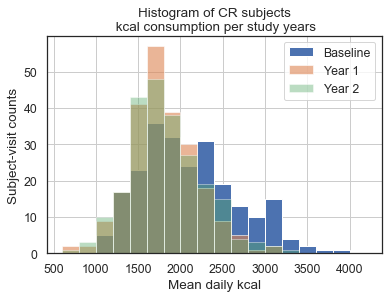

In [110]:
#  calculated only from CR subjects
a=fwn.query('year == "Baseline"').query('tx == "Caloric Restriction"')['kcal']
b=fwn.query('year == "Year 1"').query('tx == "Caloric Restriction"')['kcal']
c=fwn.query('year == "Year 2"').query('tx == "Caloric Restriction"')['kcal']
print (stats.f_oneway(a,b,c))
print ("Baseline vs Year 1", stats.ttest_ind(a,b ))
print ("Year 1 vs Year 2", stats.ttest_ind(c,b ))
print ("Baseline vs Year 2", stats.ttest_ind(a,c ))

a.hist(bins=np.arange(600.,4400.,200.), label='Baseline')
b.hist(bins=np.arange(600.,4400.,200.), label='Year 1', alpha = 0.6)
c.hist(bins=np.arange(600.,4400.,200.), label='Year 2', alpha = 0.4)

plt.ylabel('Subject-visit counts')
plt.xlabel('Mean daily kcal')
plt.title('Histogram of CR subjects\n kcal consumption per study years')
plt.legend();

F_onewayResult(statistic=1.0052106777201897, pvalue=0.36731794434550175)
Baseline vs Year 1 Ttest_indResult(statistic=0.9250065450473549, pvalue=0.35603959228119597)
Year 1 vs Year 2 Ttest_indResult(statistic=-0.32533450760817256, pvalue=0.7454391526409182)
Baseline vs Year 2 Ttest_indResult(statistic=1.309465962874759, pvalue=0.19183515460608755)


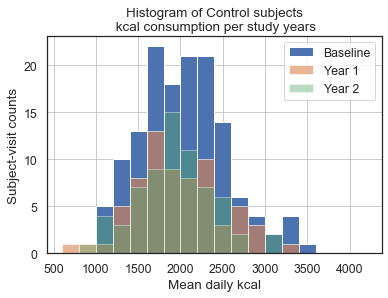

In [111]:
# calculated only from CR subjects
a=fwn.query('year == "Baseline"').query('tx == "Control"')['kcal']
b=fwn.query('year == "Year 1"').query('tx == "Control"')['kcal']
c=fwn.query('year == "Year 2"').query('tx == "Control"')['kcal']
print (stats.f_oneway(a,b,c))
print ("Baseline vs Year 1", stats.ttest_ind(a,b ))
print ("Year 1 vs Year 2", stats.ttest_ind(c,b ))
print ("Baseline vs Year 2", stats.ttest_ind(a,c ))

a.hist(bins=np.arange(600.,4400.,200.), label='Baseline')
b.hist(bins=np.arange(600.,4400.,200.), label='Year 1', alpha = 0.6)
c.hist(bins=np.arange(600.,4400.,200.), label='Year 2', alpha = 0.4)

plt.ylabel('Subject-visit counts')
plt.xlabel('Mean daily kcal')
plt.title('Histogram of Control subjects\n kcal consumption per study years')
plt.legend();